In [1]:
import numpy as np
import pandas as pd
import pickle
from kdg.utils import trunk_sim, hellinger, plot_2dsim, sample_unifrom_circle
from kdg import kdn, kdf
from sklearn.ensemble import RandomForestClassifier as rf 
from tensorflow import keras
from tensorflow.keras import activations
from joblib import Parallel, delayed
import seaborn as sns
import pickle
import matplotlib.pyplot as plt

<AxesSubplot: >

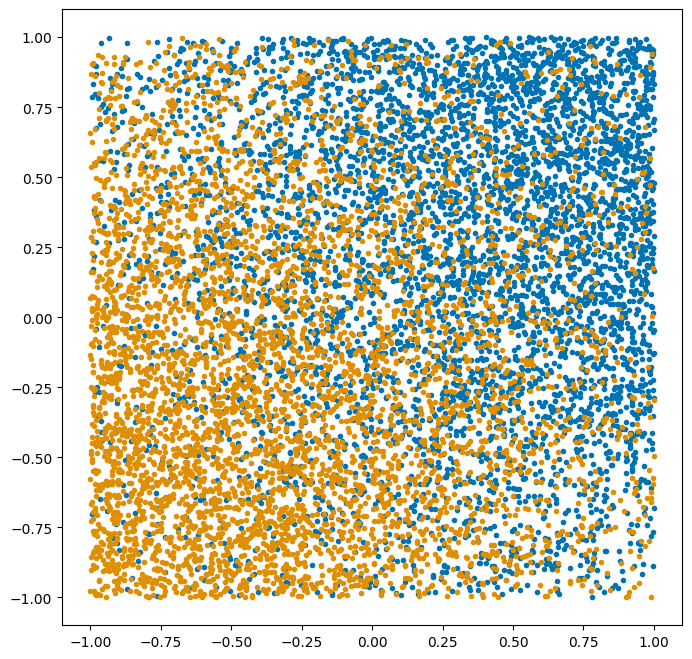

In [2]:
X, y = trunk_sim(10000, p_star=2, p=2)
X_val, y_val = trunk_sim(100, p_star=2, p=2)
plot_2dsim(X,y)

In [138]:
def get_trunk_posterior(x, p=2):
    mean = 1.0 / np.sqrt(np.arange(1, p + 1, 1))
    class1_likelihood = 0
    class2_likelihood = 0
    for ii in range(p):
        class1_likelihood += -(x[:,ii]-mean[ii])**2/(2) - .5*np.log(2*np.pi)
        class2_likelihood += -(x[:,ii]+mean[ii])**2/(2) - .5*np.log(2*np.pi)
    
    class1_likelihood = class1_likelihood.reshape(-1,1)
    class2_likelihood = class2_likelihood.reshape(-1,1)
    
    total_likelihood = np.concatenate((class1_likelihood,class2_likelihood),axis=1)
    max_likelihood = np.max(total_likelihood, axis=1).reshape(-1,1)
    class1_likelihood = np.exp(class1_likelihood-max_likelihood)
    class2_likelihood = np.exp(class2_likelihood-max_likelihood)
    
    posterior = np.hstack((class1_likelihood/(class1_likelihood+class2_likelihood),class2_likelihood/(class1_likelihood+class2_likelihood)))
                               
    return posterior

In [4]:
def getNN(input_size, num_classes, layer_size=1000):
    network_base = keras.Sequential()
    initializer = keras.initializers.random_normal(seed=0)
    network_base.add(keras.layers.Dense(layer_size, kernel_initializer=initializer, input_shape=(input_size,)))
    network_base.add(keras.layers.Activation(activations.relu))
    network_base.add(keras.layers.Dense(layer_size, kernel_initializer=initializer))
    network_base.add(keras.layers.Activation(activations.relu))
    network_base.add(keras.layers.Dense(layer_size, kernel_initializer=initializer))
    network_base.add(keras.layers.Activation(activations.relu))
    network_base.add(keras.layers.Dense(layer_size, kernel_initializer=initializer))
    network_base.add(keras.layers.Activation(activations.relu))
    network_base.add(keras.layers.Dense(units=num_classes, activation="softmax", kernel_initializer=initializer))
    network_base.compile(**compile_kwargs)
    return network_base

In [5]:
compile_kwargs = {
        "loss": "binary_crossentropy",
        "optimizer": keras.optimizers.Adam(3e-4),
    }
callback = keras.callbacks.EarlyStopping(monitor="loss", patience=10, verbose=True)
fit_kwargs = {
        "epochs": 200,
        "batch_size": 32,
        "verbose": False,
        "callbacks": [callback],
    }

In [6]:
df = {}
rf_model = rf(n_estimators=500)
rf_model.fit(X, y)
model_kdf = kdf(rf_model)
model_kdf.fit(X, y, X_val=X_val, y_val=y_val)
model_kdf.global_bias = -1e100

#define grids
p = np.arange(-2, 2, step=0.01)
q = np.arange(-2, 2, step=0.01)
xx, yy = np.meshgrid(p, q)

grid_samples = np.concatenate((xx.reshape(-1, 1), yy.reshape(-1, 1)), axis=1)
posterior_rf = model_kdf.rf_model.predict_proba(grid_samples)
posterior_kdf, likelihoods_kdf = model_kdf.predict_proba(grid_samples, return_likelihood=True)
posterior_kdf_geod, likelihoods_kdf_geod = model_kdf.predict_proba(grid_samples, distance='Geodesic', return_likelihood=True)


posterior_rf = posterior_rf[:,0].reshape(400,400)
posterior_kdf = posterior_kdf[:,0].reshape(400,400)
class1_likelihoods_kdf = likelihoods_kdf[:,0].reshape(400,400)
class2_likelihoods_kdf = likelihoods_kdf[:,1].reshape(400,400)

posterior_kdf_geod = posterior_kdf_geod[:,0].reshape(400,400)
class1_likelihoods_geod_kdf = likelihoods_kdf_geod[:,0].reshape(400,400)
class2_likelihoods_geod_kdf = likelihoods_kdf_geod[:,1].reshape(400,400)

df['posterior_rf'] = posterior_rf
df['posterior_kdf'] = posterior_kdf
df['likelihood_class1_kdf'] = class1_likelihoods_kdf
df['likelihood_class2_kdf'] = class2_likelihoods_kdf
df['posterior_kdf_geod'] = posterior_kdf_geod
df['likelihood_class1_geod_kdf'] = class1_likelihoods_geod_kdf
df['likelihood_class2_geod_kdf'] = class2_likelihoods_geod_kdf

Fitting data!


In [7]:
#define grids
p = np.arange(-2, 2, step=0.01)
q = np.arange(-2, 2, step=0.01)
xx, yy = np.meshgrid(p, q)

grid_samples = np.concatenate((xx.reshape(-1, 1), yy.reshape(-1, 1)), axis=1)

nn = getNN(
            input_size=X.shape[1],
            num_classes=2, 
            layer_size=100
        )
history = nn.fit(X, keras.utils.to_categorical(y), **fit_kwargs)
model_kdn = kdn(network=nn)
model_kdn.fit(X, y, X_val=X_val, y_val=y_val)

model_kdn.global_bias = -1e100
posterior_dn = model_kdn.network.predict(grid_samples)
posterior_kdn, likelihoods_kdn = model_kdn.predict_proba(grid_samples, return_likelihood=True)
posterior_kdn_geod, likelihoods_kdn_geod = model_kdn.predict_proba(grid_samples, distance='Geodesic', return_likelihood=True)

posterior_dn = posterior_dn[:,0].reshape(400,400)
posterior_kdn = posterior_kdn[:,0].reshape(400,400)
class1_likelihoods_kdn = likelihoods_kdn[:,0].reshape(400,400)
class2_likelihoods_kdn = likelihoods_kdn[:,1].reshape(400,400)

posterior_kdn_geod = posterior_kdn_geod[:,0].reshape(400,400)
class1_likelihoods_geod_kdn = likelihoods_kdn_geod[:,0].reshape(400,400)
class2_likelihoods_geod_kdn = likelihoods_kdn_geod[:,1].reshape(400,400)


df['posterior_dn'] = posterior_dn
df['posterior_kdn'] = posterior_kdn
df['likelihood_class1_kdn'] = class1_likelihoods_kdn
df['likelihood_class2_kdn'] = class2_likelihoods_kdn
df['posterior_kdn_geod'] = posterior_kdn_geod
df['likelihood_class1_geod_kdn'] = class1_likelihoods_geod_kdn
df['likelihood_class2_geod_kdn'] = class2_likelihoods_geod_kdn

Metal device set to: Apple M1 Max


2024-02-03 11:04:08.184823: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-02-03 11:04:08.185009: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
2024-02-03 11:04:08.406506: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2024-02-03 11:04:08.552802: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core

Epoch 27: early stopping
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:08<00:00,  1.66s/it]


Fitting data!
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 14.38it/s]


None 0.13914177481550086 0.76
1 0.14397679940661867 0.76
1 0.12399116840392166 0.76
3 0.12114829852177784 0.76
2.5 0.11184153019613521 0.76
2.6 0.11086802289815335 0.76
2.7 0.11736829082933235 0.76
2.7 0.11874445199095085 0.76
2.7 0.12399116840392166 0.76
2.7 0.13826890776591627 0.76
2.7 0.13788116546018453 0.76
2.7 0.13752829150560225 0.76
2.7 0.13720764676701405 0.76
2.7 0.1484786438117454 0.76
  74/5000 [..............................] - ETA: 10s

2024-02-03 11:06:16.395990: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


5000/5000 [==============================] - 10s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:08<00:00,  1.74s/it]


Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:08<00:00,  1.72s/it]


Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:08<00:00,  1.73s/it]


Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:08<00:00,  1.73s/it]


In [8]:
p = np.arange(-1, 1, step=0.01)
q = np.arange(-1, 1, step=0.01)
xx, yy = np.meshgrid(p, q)

grid_samples = np.concatenate((xx.reshape(-1, 1), yy.reshape(-1, 1)), axis=1)
proba_true = 0.5*np.ones((400, 400))
tmp = get_trunk_posterior(grid_samples)[:,0]

proba_true[100:300, 100:300] = tmp.reshape(200, 200)

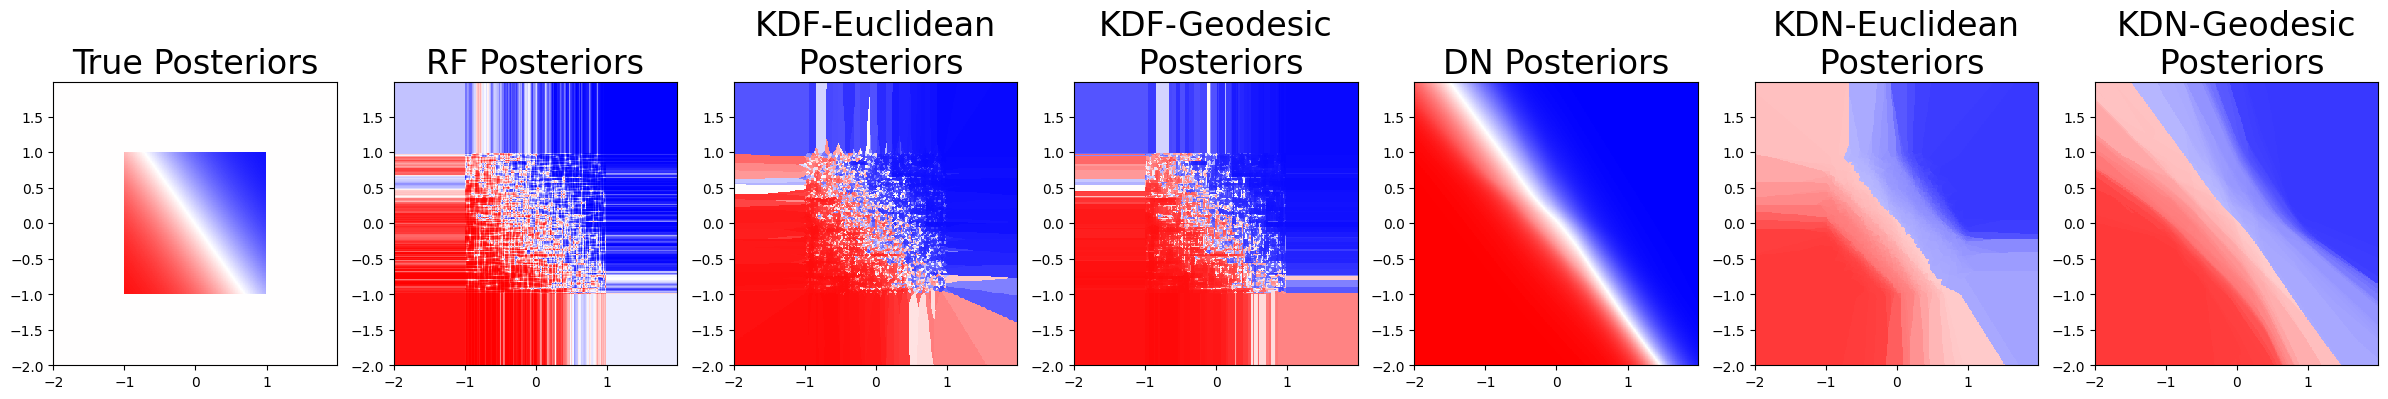

In [9]:
fig1, ax = plt.subplots(1, 7, figsize=(30, 210))

p = np.arange(-2, 2, step=0.01)
q = np.arange(-2, 2, step=0.01)
xx, yy = np.meshgrid(p, q)

ax0 = ax[0].imshow(
    np.fliplr(proba_true),
    extent=[xx.min(), xx.max(), yy.min(), yy.max()],
    cmap="bwr",
    vmin=0,
    vmax=1,
    interpolation="nearest",
    aspect="auto",
)
ax[0].set_title("True Posteriors", fontsize=24)
ax[0].set_aspect("equal")

ax1 = ax[1].imshow(
    np.fliplr(posterior_rf),
    extent=[xx.min(), xx.max(), yy.min(), yy.max()],
    cmap="bwr",
    vmin=0,
    vmax=1,
    interpolation="nearest",
    aspect="auto",
)
ax[1].set_title("RF Posteriors", fontsize=24)
ax[1].set_aspect("equal")

ax2 = ax[2].imshow(
    np.fliplr(posterior_kdf),
    extent=[xx.min(), xx.max(), yy.min(), yy.max()],
    cmap="bwr",
    vmin=0,
    vmax=1,
    interpolation="nearest",
    aspect="auto",
)
ax[2].set_title("KDF-Euclidean\n Posteriors", fontsize=24)
ax[2].set_aspect("equal")

ax2 = ax[3].imshow(
    np.fliplr(posterior_kdf_geod),
    extent=[xx.min(), xx.max(), yy.min(), yy.max()],
    cmap="bwr",
    vmin=0,
    vmax=1,
    interpolation="nearest",
    aspect="auto",
)
ax[3].set_title("KDF-Geodesic\n Posteriors", fontsize=24)
ax[3].set_aspect("equal")

ax1 = ax[4].imshow(
    np.fliplr(posterior_dn),
    extent=[xx.min(), xx.max(), yy.min(), yy.max()],
    cmap="bwr",
    vmin=0,
    vmax=1,
    interpolation="nearest",
    aspect="auto",
)
ax[4].set_title("DN Posteriors", fontsize=24)
ax[4].set_aspect("equal")

ax2 = ax[5].imshow(
    np.fliplr(posterior_kdn),
    extent=[xx.min(), xx.max(), yy.min(), yy.max()],
    cmap="bwr",
    vmin=0,
    vmax=1,
    interpolation="nearest",
    aspect="auto",
)
ax[5].set_title("KDN-Euclidean\n Posteriors", fontsize=24)
ax[5].set_aspect("equal")

ax2 = ax[6].imshow(
    np.fliplr(posterior_kdn_geod),
    extent=[xx.min(), xx.max(), yy.min(), yy.max()],
    cmap="bwr",
    vmin=0,
    vmax=1,
    interpolation="nearest",
    aspect="auto",
)
ax[6].set_title("KDN-Geodesic\n Posteriors", fontsize=24)
ax[6].set_aspect("equal")
plt.show()

In [258]:
# %%
##### main hyperparameters #####
mc_reps = 10
signal_dimension = [1, 10, 20, 30, 40, 50, 60, 70, 80, 90 ,100]
train_sample = 5000
test_sample = 1000

In [259]:
def experiment(dim):
    X, y = trunk_sim(train_sample, p_star=dim, p=dim)
    X_test, y_test = trunk_sim(test_sample, p_star=dim, p=dim)
    X_val, y_val = trunk_sim(1000, p_star=dim, p=dim)
    true_posterior = get_trunk_posterior(X_test,p=dim)

    rf_model = rf(n_estimators=500)
    rf_model.fit(X, y)
    model_kdf = kdf(rf_model)
    model_kdf.fit(X, y, X_val, y_val)
    model_kdf.global_bias = -1e20
    #model_kdf = kdf(kwargs={'n_estimators':500})
    #model_kdf.fit(X, y)

    nn = getNN(
            input_size=X.shape[1],
            num_classes=2, 
            layer_size=100
        )
    history = nn.fit(X, keras.utils.to_categorical(y), **fit_kwargs)
    model_kdn = kdn(network=nn)
    model_kdn.fit(X, y, X_val, y_val)
    model_kdn.global_bias = -1e20
    
    proba_kdf = model_kdf.predict_proba(X_test)
    proba_kdf_geodesic = model_kdf.predict_proba(X_test, distance='Geodesic')
    proba_kdn = model_kdn.predict_proba(X_test)
    proba_kdn_geodesic = model_kdn.predict_proba(X_test, distance='Geodesic')
    proba_rf = model_kdf.rf_model.predict_proba(X_test)
    proba_dn = model_kdn.network.predict(X_test)
    
    kdf_err = 1 - \
        np.mean(np.argmax(proba_kdf,axis=1)==y_test)
    kdf_err_geodesic = 1 - \
        np.mean(np.argmax(proba_kdf_geodesic,axis=1)==y_test)
    
    kdf_hellinger = hellinger(
                        true_posterior,
                        proba_kdf
                    )
    kdf_geodesic_hellinger = hellinger(
                        true_posterior,
                        proba_kdf_geodesic
                    )
    
    
    kdn_err = 1 - \
        np.mean(np.argmax(proba_kdn,axis=1)==y_test)
    kdn_err_geodesic = 1 - \
        np.mean(np.argmax(proba_kdn_geodesic,axis=1)==y_test)
    
    kdn_hellinger = hellinger(
                        true_posterior,
                        proba_kdn
                    )
    kdn_geodesic_hellinger = hellinger(
                        true_posterior,
                        proba_kdn_geodesic
                    )
    
    rf_err = 1 - \
        np.mean(np.argmax(proba_rf,axis=1)==y_test)
    dn_err = 1 - \
        np.mean(np.argmax(proba_dn,axis=1)==y_test)
    
    rf_hellinger = hellinger(
                        true_posterior,
                        proba_rf
                    )
    dn_geodesic_hellinger = hellinger(
                        true_posterior,
                        proba_dn
                    )
    
    #print(kdn_err, kdn_err_geodesic, kdf_err, kdf_err_geodesic, rf_err, dn_err, kdn_hellinger, kdn_geodesic_hellinger, kdf_hellinger, kdf_geodesic_hellinger, rf_hellinger, dn_geodesic_hellinger)
    return kdn_err, kdn_err_geodesic, kdf_err, kdf_err_geodesic, rf_err, dn_err, kdn_hellinger, kdn_geodesic_hellinger, kdf_hellinger, kdf_geodesic_hellinger, rf_hellinger, dn_geodesic_hellinger


In [260]:
err_kdn = []
err_kdf = []
err_dn = []
err_rf = []
err_kdf_geodesic = []
err_kdn_geodesic = []
hel_kdn = []
hel_kdf = []
hel_dn = []
hel_rf = []
hel_kdf_geodesic = []
hel_kdn_geodesic = []
dimension = []

for dim in signal_dimension:
    print('doing dim ', dim)
    res = []
    for _ in range(mc_reps):
        res.append(experiment(dim))
    
    for ii in range(mc_reps):
        err_kdn.append(
            res[ii][0]
        )
        err_kdn_geodesic.append(
            res[ii][1]
        )
        err_kdf.append(
            res[ii][2]
        )
        err_kdf_geodesic.append(
            res[ii][3]
        )
        err_rf.append(
            res[ii][4]
        )
        err_dn.append(
            res[ii][5]
        )
        
        hel_kdn.append(
            res[ii][6]
        )
        hel_kdn_geodesic.append(
            res[ii][7]
        )
        hel_kdf.append(
            res[ii][8]
        )
        hel_kdf_geodesic.append(
            res[ii][9]
        )
        hel_rf.append(
            res[ii][10]
        )
        hel_dn.append(
            res[ii][11]
        )
        dimension.append(
            dim
        )

df['err_kdn'] = err_kdn
df['err_kdf'] = err_kdf
df['err_dn'] = err_dn
df['err_rf'] = err_rf
df['err_kdf_geodesic'] = err_kdf_geodesic
df['err_kdn_geodesic'] = err_kdn_geodesic

df['kdn_hellinger'] = hel_kdn
df['kdf_hellinger'] = hel_kdf
df['dn_hellinger'] = hel_dn
df['rf_hellinger'] = hel_rf
df['kdf_geodesic_hellinger'] = hel_kdf_geodesic
df['kdn_geodesic_hellinger'] = hel_kdn_geodesic

df['dimension'] = dimension


doing dim  1
Fitting data!


2024-02-06 16:39:48.258193: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x32x1x2xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x32x1x2xi1>'
loc

Epoch 30: early stopping
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  1.86it/s]


Fitting data!
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.47it/s]


None 0.08517767526942784 0.712
1 0.03839085440300442 0.712
2 0.025206513272885415 0.712
3 0.033757531840591125 0.712
3 0.03250542872936334 0.712
3 0.031066782609607296 0.712
3 0.025556861673538656 0.712
3 0.024823064280189627 0.712
2.9000000000000004 0.02520651327288549 0.712
2.9000000000000004 0.025158480144524584 0.712
2.9000000000000004 0.024627394308745023 0.712
3.2000000000000006 0.02633913466307484 0.712
3.2000000000000006 0.02260193654766683 0.712
3.400000000000001 0.02476678089571177 0.712
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.61it/s]


 1/32 [..............................] - ETA: 3s

2024-02-06 16:40:50.322961: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 5ms/step
Fitting data!


2024-02-06 16:41:34.972060: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x32x1x2xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x32x1x2xi1>'
loc

Epoch 37: early stopping
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  1.87it/s]


Fitting data!
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.49it/s]


None 0.0420402830550705 0.706
1 0.04581903937282071 0.706
1 0.040180404940790164 0.706
3 0.0453554110523402 0.706
3 0.04512902179350239 0.706
3 0.050625146185243726 0.706
3 0.04837114688957646 0.706
3 0.045206429365883864 0.706
3 0.04018040494079017 0.706
3 0.034207003902564086 0.706
3.1000000000000005 0.03668242666159397 0.706
3.1000000000000005 0.03881938370328294 0.706
3.1000000000000005 0.04078833717557142 0.706
3.1000000000000005 0.03930901319683269 0.706
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.55it/s]
2024-02-06 16:42:44.200935: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 1s 8ms/step
Fitting data!


2024-02-06 16:43:30.325997: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x32x1x2xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x32x1x2xi1>'
loc

Epoch 60: early stopping
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  1.86it/s]


Fitting data!
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.53it/s]


None 0.04040449620915375 0.707
1 0.04671078100634996 0.707
1 0.041544200990280965 0.707
1 0.021049379757728515 0.707
0.5 0.02129349969781814 0.707
0.5 0.021491276999279475 0.707
0.5 0.02164597422322065 0.707
0.5 0.02176096713869884 0.707
0.5 0.040404496209153734 0.707
0.5 0.04020136431386493 0.707
0.5 0.04031655129244177 0.707
0.5 0.03993452791307904 0.707
0.5 0.04491832087249381 0.707
0.5 0.05087008965697331 0.707
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.58it/s]
2024-02-06 16:45:06.686334: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 1s 10ms/step
Fitting data!


2024-02-06 16:45:51.780710: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x32x1x2xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x32x1x2xi1>'
loc

Epoch 46: early stopping
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  1.86it/s]


Fitting data!
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.58it/s]


None 0.0667942721647685 0.733
1 0.0728407866929694 0.733
1 0.06525857934606037 0.733
3 0.06918065042442781 0.733
3 0.06815537517191816 0.733
3 0.06819298346823684 0.733
3 0.06719575184684473 0.733
3 0.06621746414382135 0.733
3 0.06525857934606032 0.733
3.0000000000000004 0.06431945402401851 0.733
3.1000000000000005 0.06340034127631708 0.733
3.2000000000000006 0.06250139294560277 0.733
3.3000000000000007 0.06162266433109849 0.733
3.400000000000001 0.0607641206936045 0.733
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.11it/s]
2024-02-06 16:47:12.688225: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 1s 12ms/step
Fitting data!


2024-02-06 16:47:59.751465: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x32x1x2xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x32x1x2xi1>'
loc

Epoch 41: early stopping
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  1.89it/s]


Fitting data!
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.12it/s]


None 0.029110418465788088 0.686
1 0.0535772668233442 0.686
1 0.054579598439672465 0.686
1 0.023970566794984556 0.686
0.5 0.024618930719742943 0.686
0.5 0.025150705641960806 0.686
0.5 0.035246963403961745 0.686
0.5 0.0276512178786855 0.686
0.5 0.029110418465788088 0.686
0.5 0.02978539680282286 0.686
0.5 0.0316535157670332 0.686
0.5 0.04161719583268841 0.686
0.5 0.054833106788880946 0.686
0.5 0.05512615792639205 0.686
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.26it/s]
2024-02-06 16:49:14.191090: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 1s 10ms/step
Fitting data!


2024-02-06 16:50:00.204314: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x32x1x2xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x32x1x2xi1>'
loc

Epoch 37: early stopping
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  1.89it/s]


Fitting data!
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.56it/s]


None 0.012826777105183441 0.713
1 0.031169423697898626 0.713
1 0.027873816044454793 0.713
1 0.022163393339772502 0.713
1 0.015039836860216827 0.713
1 0.010259323979895395 0.713
0.7 0.01103740864267226 0.713
0.7 0.01370199596638362 0.713
0.7 0.012826777105183446 0.713
0.7 0.025115336443259174 0.713
0.7 0.02200804631793939 0.713
0.7 0.023857889804476073 0.713
0.7 0.0224504995641711 0.713
0.7 0.028814841569894837 0.713
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.50it/s]
2024-02-06 16:51:10.278891: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 1s 11ms/step
Fitting data!


2024-02-06 16:51:56.205050: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x32x1x2xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x32x1x2xi1>'
loc

Epoch 32: early stopping
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  1.75it/s]


Fitting data!
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.52it/s]


None 0.07660802532980698 0.713
1 0.08215146492515354 0.713
1 0.07536485253376037 0.713
3 0.08109230034079352 0.713
3 0.08221837526276292 0.713
3 0.08125256459323446 0.713
3 0.07723922772444837 0.713
3 0.07629253624350411 0.713
3 0.07536485253376037 0.713
3 0.07445590198374037 0.713
3.1000000000000005 0.06699774228185049 0.713
3.2000000000000006 0.06151640052317363 0.713
3.3000000000000007 0.06008427131189408 0.713
3.400000000000001 0.061879733554296844 0.713
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.59it/s]
2024-02-06 16:53:01.778360: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 1s 10ms/step
Fitting data!


2024-02-06 16:53:47.904778: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x32x1x2xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x32x1x2xi1>'
loc

Epoch 27: early stopping
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  1.89it/s]


Fitting data!
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.47it/s]


None 0.031129230604145824 0.708
1 0.03788403987404239 0.708
1 0.03679686557541824 0.708
1 0.02520734734591526 0.708
0.5 0.029045292243646267 0.708
0.5 0.02989435487536053 0.708
0.5 0.03232540176124503 0.708
0.5 0.031917160115232004 0.708
0.5 0.031129230604145824 0.708
0.5 0.034907556800233774 0.708
0.5 0.035675935322580885 0.708
0.5 0.046256650703564696 0.708
0.5 0.03559088165240553 0.708
0.5 0.030647878027335193 0.708
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.35it/s]
2024-02-06 16:54:46.823950: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 1s 11ms/step
Fitting data!


2024-02-06 16:55:32.557981: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x32x1x2xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x32x1x2xi1>'
loc

Epoch 43: early stopping
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  1.87it/s]


Fitting data!
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.57it/s]


None 0.05814112158894053 0.716
1 0.05733829793683697 0.716
2 0.05838840988546092 0.716
2 0.04967955475885726 0.716
1.5 0.054015794242939834 0.716
1.5 0.05586560861973419 0.716
1.5 0.05655789618423837 0.716
1.5 0.0573616687957021 0.716
1.5 0.057338297936836945 0.716
1.5 0.055359191541716285 0.716
1.5 0.05477693752050887 0.716
1.5 0.05381297985070047 0.716
1.5 0.05425803607788156 0.716
1.5 0.054642067218294246 0.716
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.09it/s]
2024-02-06 16:56:49.211320: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 5ms/step
Fitting data!


2024-02-06 17:01:16.084819: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x32x1x2xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x32x1x2xi1>'
loc

Epoch 31: early stopping
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  1.84it/s]


Fitting data!
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.50it/s]


None 0.03369559184217375 0.701
1 0.0546224368198799 0.701
1 0.04833343793101577 0.701
1 0.024092373804958624 0.701
0.5 0.024910055776371537 0.701
0.5 0.02815636163007437 0.701
0.5 0.03444969486429885 0.701
0.5 0.032806835112362445 0.701
0.5 0.03369559184217375 0.701
0.5 0.034494006773275326 0.701
0.5 0.03520905790253937 0.701
0.5 0.035847136098575975 0.701
0.5 0.0760249396776029 0.701
0.5 0.07509024170729309 0.701
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.33it/s]
2024-02-06 17:04:16.843482: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 1s 11ms/step
doing dim  10
Fitting data!


2024-02-06 17:05:17.604493: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x32x1x2xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x32x1x2xi1>'
loc

Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  1.82it/s]


Fitting data!
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  4.43it/s]


None 0.2443269671784265 0.745
1 0.24493467341095357 0.745
1 0.24372674123321975 0.745
3 0.24458991744411693 0.745
3 0.2444622620888943 0.745
3 0.2443130256531106 0.745
3 0.2441412753795576 0.745
3 0.24394611580023168 0.745
3 0.24372674123321975 0.745
3 0.243482494260357 0.745
3.1000000000000005 0.24321292811656475 0.745
3.2000000000000006 0.24291787002008192 0.745
3.3000000000000007 0.24259748162331704 0.745
3.400000000000001 0.24225231210624606 0.745
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  4.55it/s]
2024-02-06 17:45:59.124909: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 1s 10ms/step
Fitting data!


2024-02-06 17:46:50.812642: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x32x1x2xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x32x1x2xi1>'
loc

Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  1.89it/s]


Fitting data!
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  4.54it/s]


None 0.2738381275828442 0.719
1 0.27417208086620265 0.719
1 0.27315757688585424 0.719
3 0.2738048204315637 0.719
3 0.27369722479318676 0.719
3 0.273578667365914 0.719
3 0.2737882068001195 0.719
3 0.27330885129172283 0.719
3 0.27315757688585424 0.719
3 0.27342023256859976 0.719
3 0.27327991732540785 0.719
3 0.27304386146897025 0.719
3.3000000000000007 0.2729728705922652 0.719
3.400000000000001 0.2728061009121162 0.719
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  4.55it/s]
2024-02-06 17:51:21.189524: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 1s 14ms/step
Fitting data!


2024-02-06 17:52:11.605491: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x32x1x2xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x32x1x2xi1>'
loc

Epoch 152: early stopping
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  1.88it/s]


Fitting data!
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  4.45it/s]


None 0.20785881658107475 0.763
1 0.20970413239261704 0.763
1 0.21093312297558228 0.763
1 0.20671888526907267 0.763
0.5 0.20695365584897019 0.763
0.5 0.20718588347185363 0.763
0.5 0.20741467377237277 0.763
0.5 0.20763921943777763 0.763
0.5 0.20785881658107475 0.763
0.5 0.2082874109429307 0.763
0.5 0.20860947424277884 0.763
0.5 0.20903770867204732 0.763
0.5 0.20867756991741393 0.763
0.5 0.20886576297338105 0.763
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  4.27it/s]
2024-02-06 17:55:42.465133: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 1s 10ms/step
Fitting data!


2024-02-06 17:56:34.429077: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x32x1x2xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x32x1x2xi1>'
loc

Epoch 160: early stopping
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  1.86it/s]


Fitting data!
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  4.53it/s]


None 0.2242455276859937 0.769
1 0.22446245201984094 0.769
1 0.22486990051154623 0.769
1 0.22390500328713658 0.769
0.5 0.2239933068857537 0.769
0.5 0.2240709280080424 0.769
0.5 0.22413846220762457 0.769
0.5 0.22419647912900412 0.769
0.5 0.2242455276859937 0.769
0.5 0.2242861401893087 0.769
0.5 0.22431883547001052 0.769
0.5 0.2243441210861724 0.769
0.5 0.22436249472532688 0.769
0.5 0.22437444493143788 0.769
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  4.54it/s]
2024-02-06 18:00:12.171124: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 1s 10ms/step
Fitting data!


2024-02-06 18:01:01.875502: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x32x1x2xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x32x1x2xi1>'
loc

Epoch 185: early stopping
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  1.86it/s]


Fitting data!
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  4.58it/s]


None 0.2157783821521806 0.772
1 0.21604895968679005 0.772
1 0.21572865367454241 0.772
3 0.21611818034029084 0.772
3 0.2160965420905794 0.772
3 0.2160755397685737 0.772
3 0.2160558919847226 0.772
3 0.21603825808268448 0.772
3 0.21572865367454241 0.772
3 0.21569613965775783 0.772
3.1000000000000005 0.21600313290628753 0.772
3.1000000000000005 0.2159989396545513 0.772
3.1000000000000005 0.2159991380849687 0.772
3.1000000000000005 0.21600400680162546 0.772
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  4.62it/s]
2024-02-06 18:05:05.672284: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 8ms/step
Fitting data!


2024-02-06 18:05:57.004340: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x32x1x2xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x32x1x2xi1>'
loc

Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  1.88it/s]


Fitting data!
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  4.57it/s]


None 0.25029072126817875 0.749
1 0.2502405834951552 0.749
2 0.25019769215532006 0.749
3 0.25021828432367577 0.749
3 0.2502140615364281 0.749
3 0.2502099030504876 0.749
3 0.2502057978869098 0.749
3 0.2502017327584902 0.749
3 0.25019769215532006 0.749
3 0.25019365846081865 0.749
3.1000000000000005 0.2501896120919911 0.749
3.2000000000000006 0.25018553165857094 0.749
3.3000000000000007 0.2501813941369243 0.749
3.400000000000001 0.2501771750558335 0.749
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  4.57it/s]
2024-02-06 18:10:18.331322: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 5ms/step
Fitting data!


2024-02-06 18:11:08.643521: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x32x1x2xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x32x1x2xi1>'
loc

Epoch 190: early stopping
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  1.94it/s]


Fitting data!
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  4.51it/s]


None 0.21562249980706563 0.762
1 0.217828491274929 0.762
1 0.21809734255277044 0.762
1 0.2133477954568929 0.762
0.5 0.21388593571225537 0.762
0.5 0.21437881885587806 0.762
0.5 0.21483053044737535 0.762
0.5 0.2152442467145425 0.762
0.5 0.21562249980706563 0.762
0.5 0.21596737533951782 0.762
0.5 0.2162806604891207 0.762
0.5 0.21656395448474633 0.762
0.5 0.21681874878994858 0.762
0.5 0.2170464816076659 0.762
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  4.58it/s]
2024-02-06 18:15:20.328907: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 1s 12ms/step
Fitting data!


2024-02-06 18:16:11.122231: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x32x1x2xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x32x1x2xi1>'
loc

Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  1.86it/s]


Fitting data!
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  4.58it/s]


None 0.23580239312594575 0.764
1 0.23581271885795174 0.764
1 0.2358215542260077 0.764
1 0.23580037825723388 0.764
0.5 0.23580047824970551 0.764
0.5 0.23580074434806142 0.764
0.5 0.23580116208251523 0.764
0.5 0.2358017166594445 0.764
0.5 0.23580239312594575 0.764
0.5 0.2358031765225218 0.764
0.5 0.23580405202183974 0.764
0.5 0.23580500505212332 0.764
0.5 0.2358060214044062 0.764
0.5 0.23580708732336575 0.764
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  4.59it/s]
2024-02-06 18:20:32.604757: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 1s 13ms/step
Fitting data!


2024-02-06 18:21:22.467907: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x32x1x2xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x32x1x2xi1>'
loc

Epoch 196: early stopping
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  1.88it/s]


Fitting data!
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  4.58it/s]


None 0.24402855269102497 0.754
1 0.24405437417479992 0.754
1 0.24393770295176365 0.754
3 0.24400592685840705 0.754
3 0.24399371710655104 0.754
3 0.24398078505043508 0.754
3 0.24396714338656966 0.754
3 0.24395278867548553 0.754
3 0.24393770295176365 0.754
3 0.2439218553730361 0.754
3.1000000000000005 0.24390520390607048 0.754
3.2000000000000006 0.24388769704891736 0.754
3.3000000000000007 0.2438692755870587 0.754
3.400000000000001 0.24384987437767724 0.754
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  4.57it/s]
2024-02-06 18:25:39.042053: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 1s 13ms/step
Fitting data!


2024-02-06 18:26:29.061330: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x32x1x2xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x32x1x2xi1>'
loc

Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  1.85it/s]


Fitting data!
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  4.54it/s]


None 0.24537769989049252 0.75
1 0.2446983636686032 0.75
2 0.2439184084244631 0.75
3 0.24432143419467478 0.75
3 0.2442429945145006 0.75
3 0.24416349542587068 0.75
3 0.24408291447418629 0.75
3 0.24400122737235663 0.75
3 0.2439184084244631 0.75
3 0.2438344310919346 0.75
3.1000000000000005 0.24374926874626612 0.75
3.2000000000000006 0.24400706294961583 0.75
3.2000000000000006 0.24395758496646905 0.75
3.2000000000000006 0.2439110222615767 0.75
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  4.59it/s]
2024-02-06 18:30:50.029512: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 5ms/step
doing dim  20
Fitting data!


2024-02-06 18:31:42.544817: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x32x1x2xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x32x1x2xi1>'
loc

Epoch 85: early stopping
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  1.86it/s]


Fitting data!
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  4.58it/s]


None 0.2078818966700302 0.792
1 0.20792853587219406 0.792
1 0.2079588806156768 0.792
1 0.20785088826415155 0.792
0.5 0.20785755839339914 0.792
0.5 0.20786398675785478 0.792
0.5 0.20787018117836278 0.792
0.5 0.20787614889790007 0.792
0.5 0.2078818966700302 0.792
0.5 0.207887430834237 0.792
0.5 0.20789275738011948 0.792
0.5 0.2078978820022448 0.792
0.5 0.20790281014715706 0.792
0.5 0.20790754705379888 0.792
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  4.61it/s]
2024-02-06 18:33:50.913735: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 1s 14ms/step
Fitting data!


2024-02-06 18:34:42.427229: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x32x1x2xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x32x1x2xi1>'
loc

Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  1.87it/s]


Fitting data!
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  4.59it/s]


None 0.21899999999999997 0.781
1 0.21899999999999997 0.781
1 0.21899999999999997 0.781
1 0.21899999999999997 0.781
1 0.21899999999999997 0.781
1 0.21899999999999997 0.781
1 0.21899999999999997 0.781
1 0.21899999999999997 0.781
1 0.21899999999999997 0.781
1 0.21899999999999997 0.781
1 0.21899999999999997 0.781
1 0.21899999999999997 0.781
1 0.21899999999999997 0.781
1 0.21899999999999997 0.781
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  4.55it/s]
2024-02-06 18:39:03.171570: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 1s 10ms/step
Fitting data!


2024-02-06 18:39:54.953544: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x32x1x2xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x32x1x2xi1>'
loc

Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  1.89it/s]


Fitting data!
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  4.57it/s]


None 0.19699999999999995 0.803
1 0.19699999999999995 0.803
1 0.19699999999999995 0.803
1 0.19699999999999995 0.803
1 0.19699999999999995 0.803
1 0.19699999999999995 0.803
1 0.19699999999999995 0.803
1 0.19699999999999995 0.803
1 0.19699999999999995 0.803
1 0.19699999999999995 0.803
1 0.19699999999999995 0.803
1 0.19699999999999995 0.803
1 0.19699999999999995 0.803
1 0.19699999999999995 0.803
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  4.58it/s]
2024-02-06 18:44:17.035457: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 8ms/step
Fitting data!


2024-02-06 18:45:08.389608: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x32x1x2xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x32x1x2xi1>'
loc

Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  1.89it/s]


Fitting data!
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  4.55it/s]


None 0.23099999999999998 0.769
1 0.23099999999999998 0.769
1 0.23099999999999998 0.769
1 0.23099999999999998 0.769
1 0.23099999999999998 0.769
1 0.23099999999999998 0.769
1 0.23099999999999998 0.769
1 0.23099999999999998 0.769
1 0.23099999999999998 0.769
1 0.23099999999999998 0.769
1 0.23099999999999998 0.769
1 0.23099999999999998 0.769
1 0.23099999999999998 0.769
1 0.23099999999999998 0.769
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  4.55it/s]
2024-02-06 18:49:29.702111: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 1s 10ms/step
Fitting data!


2024-02-06 18:50:21.539035: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x32x1x2xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x32x1x2xi1>'
loc

Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  1.87it/s]


Fitting data!
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  4.57it/s]


None 0.22799999999999998 0.772
1 0.22799999999999998 0.772
1 0.22799999999999998 0.772
1 0.22799999999999998 0.772
1 0.22799999999999998 0.772
1 0.22799999999999998 0.772
1 0.22799999999999998 0.772
1 0.22799999999999998 0.772
1 0.22799999999999998 0.772
1 0.22799999999999998 0.772
1 0.22799999999999998 0.772
1 0.22799999999999998 0.772
1 0.22799999999999998 0.772
1 0.22799999999999998 0.772
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  4.57it/s]
2024-02-06 18:54:46.028894: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 1s 10ms/step
Fitting data!


2024-02-06 18:55:37.647633: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x32x1x2xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x32x1x2xi1>'
loc

Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  1.94it/s]


Fitting data!
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  4.57it/s]


None 0.19899999999999995 0.801
1 0.19899999999999995 0.801
1 0.19899999999999995 0.801
1 0.19899999999999995 0.801
1 0.19899999999999995 0.801
1 0.19899999999999995 0.801
1 0.19899999999999995 0.801
1 0.19899999999999995 0.801
1 0.19899999999999995 0.801
1 0.19899999999999995 0.801
1 0.19899999999999995 0.801
1 0.19899999999999995 0.801
1 0.19899999999999995 0.801
1 0.19899999999999995 0.801
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  4.59it/s]
2024-02-06 18:59:58.226777: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 1s 13ms/step
Fitting data!


2024-02-06 19:00:50.585219: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x32x1x2xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x32x1x2xi1>'
loc

Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  1.85it/s]


Fitting data!
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  4.59it/s]


None 0.20399999999999996 0.796
1 0.20399999999999996 0.796
1 0.20399999999999996 0.796
1 0.20399999999999996 0.796
1 0.20399999999999996 0.796
1 0.20399999999999996 0.796
1 0.20399999999999996 0.796
1 0.20399999999999996 0.796
1 0.20399999999999996 0.796
1 0.20399999999999996 0.796
1 0.20399999999999996 0.796
1 0.20399999999999996 0.796
1 0.20399999999999996 0.796
1 0.20399999999999996 0.796
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  4.61it/s]
2024-02-06 19:05:12.037060: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 1s 10ms/step
Fitting data!


2024-02-06 19:06:03.931205: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x32x1x2xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x32x1x2xi1>'
loc

Epoch 86: early stopping
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  1.84it/s]


Fitting data!
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  4.58it/s]


None 0.21799999999999997 0.782
1 0.21799999999999997 0.782
1 0.21799999999999997 0.782
1 0.21799999999999997 0.782
1 0.21799999999999997 0.782
1 0.21799999999999997 0.782
1 0.21799999999999997 0.782
1 0.21799999999999997 0.782
1 0.21799999999999997 0.782
1 0.21799999999999997 0.782
1 0.21799999999999997 0.782
1 0.21799999999999997 0.782
1 0.21799999999999997 0.782
1 0.21799999999999997 0.782
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  4.58it/s]
2024-02-06 19:08:13.961316: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 12ms/step
Fitting data!


2024-02-06 19:09:06.119713: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x32x1x2xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x32x1x2xi1>'
loc

Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  1.89it/s]


Fitting data!
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  4.52it/s]


None 0.22599999999999998 0.774
1 0.22599999999999998 0.774
1 0.22599999999999998 0.774
1 0.22599999999999998 0.774
1 0.22599999999999998 0.774
1 0.22599999999999998 0.774
1 0.22599999999999998 0.774
1 0.22599999999999998 0.774
1 0.22599999999999998 0.774
1 0.22599999999999998 0.774
1 0.22599999999999998 0.774
1 0.22599999999999998 0.774
1 0.22599999999999998 0.774
1 0.22599999999999998 0.774
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  4.59it/s]
2024-02-06 19:13:27.655041: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 1s 13ms/step
Fitting data!


2024-02-06 19:14:20.311985: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x32x1x2xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x32x1x2xi1>'
loc

Epoch 115: early stopping
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  1.87it/s]


Fitting data!
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  4.61it/s]


None 0.21099999999999997 0.789
1 0.21099999999999997 0.789
1 0.21099999999999997 0.789
1 0.21099999999999997 0.789
1 0.21099999999999997 0.789
1 0.21099999999999997 0.789
1 0.21099999999999997 0.789
1 0.21099999999999997 0.789
1 0.21099999999999997 0.789
1 0.21099999999999997 0.789
1 0.21099999999999997 0.789
1 0.21099999999999997 0.789
1 0.21099999999999997 0.789
1 0.21099999999999997 0.789
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  4.60it/s]
2024-02-06 19:17:07.146898: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 8ms/step
doing dim  30
Fitting data!


2024-02-06 19:18:01.145091: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x32x1x2xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x32x1x2xi1>'
loc

Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  1.89it/s]


Fitting data!
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  4.57it/s]


None 0.19299999999999995 0.807
1 0.19299999999999995 0.807
1 0.19299999999999995 0.807
1 0.19299999999999995 0.807
1 0.19299999999999995 0.807
1 0.19299999999999995 0.807
1 0.19299999999999995 0.807
1 0.19299999999999995 0.807
1 0.19299999999999995 0.807
1 0.19299999999999995 0.807
1 0.19299999999999995 0.807
1 0.19299999999999995 0.807
1 0.19299999999999995 0.807
1 0.19299999999999995 0.807
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  4.57it/s]
2024-02-06 19:22:22.896549: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 1s 10ms/step
Fitting data!


2024-02-06 19:23:16.635349: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x32x1x2xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x32x1x2xi1>'
loc

Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  1.86it/s]


Fitting data!
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  4.53it/s]


None 0.18700000000000006 0.813
1 0.18700000000000006 0.813
1 0.18700000000000006 0.813
1 0.18700000000000006 0.813
1 0.18700000000000006 0.813
1 0.18700000000000006 0.813
1 0.18700000000000006 0.813
1 0.18700000000000006 0.813
1 0.18700000000000006 0.813
1 0.18700000000000006 0.813
1 0.18700000000000006 0.813
1 0.18700000000000006 0.813
1 0.18700000000000006 0.813
1 0.18700000000000006 0.813
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  4.54it/s]
2024-02-06 19:27:39.636400: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 1s 10ms/step
Fitting data!


2024-02-06 19:28:34.084503: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x32x1x2xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x32x1x2xi1>'
loc

Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  1.85it/s]


Fitting data!
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  4.48it/s]


None 0.18700000000000006 0.813
1 0.18700000000000006 0.813
1 0.18700000000000006 0.813
1 0.18700000000000006 0.813
1 0.18700000000000006 0.813
1 0.18700000000000006 0.813
1 0.18700000000000006 0.813
1 0.18700000000000006 0.813
1 0.18700000000000006 0.813
1 0.18700000000000006 0.813
1 0.18700000000000006 0.813
1 0.18700000000000006 0.813
1 0.18700000000000006 0.813
1 0.18700000000000006 0.813
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  4.49it/s]
2024-02-06 19:32:57.923917: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 1s 11ms/step
Fitting data!


2024-02-06 19:33:51.868898: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x32x1x2xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x32x1x2xi1>'
loc

Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  1.86it/s]


Fitting data!
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  4.53it/s]


None 0.19899999999999995 0.801
1 0.19899999999999995 0.801
1 0.19899999999999995 0.801
1 0.19899999999999995 0.801
1 0.19899999999999995 0.801
1 0.19899999999999995 0.801
1 0.19899999999999995 0.801
1 0.19899999999999995 0.801
1 0.19899999999999995 0.801
1 0.19899999999999995 0.801
1 0.19899999999999995 0.801
1 0.19899999999999995 0.801
1 0.19899999999999995 0.801
1 0.19899999999999995 0.801
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  4.49it/s]
2024-02-06 19:38:18.509786: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 1s 13ms/step
Fitting data!


2024-02-06 19:39:13.048357: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x32x1x2xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x32x1x2xi1>'
loc

Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  1.89it/s]


Fitting data!
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  4.41it/s]


None 0.19399999999999995 0.806
1 0.19399999999999995 0.806
1 0.19399999999999995 0.806
1 0.19399999999999995 0.806
1 0.19399999999999995 0.806
1 0.19399999999999995 0.806
1 0.19399999999999995 0.806
1 0.19399999999999995 0.806
1 0.19399999999999995 0.806
1 0.19399999999999995 0.806
1 0.19399999999999995 0.806
1 0.19399999999999995 0.806
1 0.19399999999999995 0.806
1 0.19399999999999995 0.806
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  4.18it/s]
2024-02-06 19:43:39.641300: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 1s 12ms/step
Fitting data!


2024-02-06 19:44:34.701526: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x32x1x2xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x32x1x2xi1>'
loc

Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  1.88it/s]


Fitting data!
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  4.56it/s]


None 0.18799999999999994 0.812
1 0.18799999999999994 0.812
1 0.18799999999999994 0.812
1 0.18799999999999994 0.812
1 0.18799999999999994 0.812
1 0.18799999999999994 0.812
1 0.18799999999999994 0.812
1 0.18799999999999994 0.812
1 0.18799999999999994 0.812
1 0.18799999999999994 0.812
1 0.18799999999999994 0.812
1 0.18799999999999994 0.812
1 0.18799999999999994 0.812
1 0.18799999999999994 0.812
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  4.57it/s]
2024-02-06 19:48:58.609592: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 1s 11ms/step
Fitting data!


2024-02-06 19:49:52.184706: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x32x1x2xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x32x1x2xi1>'
loc

Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  1.89it/s]


Fitting data!
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  4.56it/s]


None 0.19799999999999995 0.802
1 0.19799999999999995 0.802
1 0.19799999999999995 0.802
1 0.19799999999999995 0.802
1 0.19799999999999995 0.802
1 0.19799999999999995 0.802
1 0.19799999999999995 0.802
1 0.19799999999999995 0.802
1 0.19799999999999995 0.802
1 0.19799999999999995 0.802
1 0.19799999999999995 0.802
1 0.19799999999999995 0.802
1 0.19799999999999995 0.802
1 0.19799999999999995 0.802
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  4.53it/s]
2024-02-06 19:54:15.710190: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 1s 13ms/step
Fitting data!


2024-02-06 19:55:09.365274: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x32x1x2xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x32x1x2xi1>'
loc

Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  1.89it/s]


Fitting data!
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  4.33it/s]


None 0.17600000000000005 0.824
1 0.17600000000000005 0.824
1 0.17600000000000005 0.824
1 0.17600000000000005 0.824
1 0.17600000000000005 0.824
1 0.17600000000000005 0.824
1 0.17600000000000005 0.824
1 0.17600000000000005 0.824
1 0.17600000000000005 0.824
1 0.17600000000000005 0.824
1 0.17600000000000005 0.824
1 0.17600000000000005 0.824
1 0.17600000000000005 0.824
1 0.17600000000000005 0.824
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  4.08it/s]
2024-02-06 19:59:38.215582: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 1s 11ms/step
Fitting data!


2024-02-06 20:00:34.795552: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x32x1x2xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x32x1x2xi1>'
loc

Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  1.81it/s]


Fitting data!
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  4.28it/s]


None 0.18500000000000005 0.815
1 0.18500000000000005 0.815
1 0.18500000000000005 0.815
1 0.18500000000000005 0.815
1 0.18500000000000005 0.815
1 0.18500000000000005 0.815
1 0.18500000000000005 0.815
1 0.18500000000000005 0.815
1 0.18500000000000005 0.815
1 0.18500000000000005 0.815
1 0.18500000000000005 0.815
1 0.18500000000000005 0.815
1 0.18500000000000005 0.815
1 0.18500000000000005 0.815
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  4.32it/s]
2024-02-06 20:05:04.427091: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 1s 17ms/step
Fitting data!


2024-02-06 20:06:01.644658: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x32x1x2xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x32x1x2xi1>'
loc

Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  1.82it/s]


Fitting data!
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  4.32it/s]


None 0.18600000000000005 0.814
1 0.18600000000000005 0.814
1 0.18600000000000005 0.814
1 0.18600000000000005 0.814
1 0.18600000000000005 0.814
1 0.18600000000000005 0.814
1 0.18600000000000005 0.814
1 0.18600000000000005 0.814
1 0.18600000000000005 0.814
1 0.18600000000000005 0.814
1 0.18600000000000005 0.814
1 0.18600000000000005 0.814
1 0.18600000000000005 0.814
1 0.18600000000000005 0.814
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  4.25it/s]
2024-02-06 20:10:30.540428: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 1s 8ms/step
doing dim  40
Fitting data!


2024-02-06 20:11:29.025698: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x32x1x2xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x32x1x2xi1>'
loc

Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  1.74it/s]


Fitting data!
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  4.29it/s]


None 0.16400000000000003 0.836
1 0.16400000000000003 0.836
1 0.16400000000000003 0.836
1 0.16400000000000003 0.836
1 0.16400000000000003 0.836
1 0.16400000000000003 0.836
1 0.16400000000000003 0.836
1 0.16400000000000003 0.836
1 0.16400000000000003 0.836
1 0.16400000000000003 0.836
1 0.16400000000000003 0.836
1 0.16400000000000003 0.836
1 0.16400000000000003 0.836
1 0.16400000000000003 0.836
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  4.02it/s]
2024-02-06 20:16:06.479954: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 1s 12ms/step
Fitting data!


2024-02-06 20:17:04.916023: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x32x1x2xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x32x1x2xi1>'
loc

Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  1.86it/s]


Fitting data!
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  4.29it/s]


None 0.17700000000000005 0.823
1 0.17700000000000005 0.823
1 0.17700000000000005 0.823
1 0.17700000000000005 0.823
1 0.17700000000000005 0.823
1 0.17700000000000005 0.823
1 0.17700000000000005 0.823
1 0.17700000000000005 0.823
1 0.17700000000000005 0.823
1 0.17700000000000005 0.823
1 0.17700000000000005 0.823
1 0.17700000000000005 0.823
1 0.17700000000000005 0.823
1 0.17700000000000005 0.823
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  3.85it/s]
2024-02-06 20:21:38.651056: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 1s 16ms/step
Fitting data!


2024-02-06 20:22:37.257129: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x32x1x2xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x32x1x2xi1>'
loc

Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  1.79it/s]


Fitting data!
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  4.01it/s]


None 0.17800000000000005 0.822
1 0.17800000000000005 0.822
1 0.17800000000000005 0.822
1 0.17800000000000005 0.822
1 0.17800000000000005 0.822
1 0.17800000000000005 0.822
1 0.17800000000000005 0.822
1 0.17800000000000005 0.822
1 0.17800000000000005 0.822
1 0.17800000000000005 0.822
1 0.17800000000000005 0.822
1 0.17800000000000005 0.822
1 0.17800000000000005 0.822
1 0.17800000000000005 0.822
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  4.23it/s]
2024-02-06 20:27:15.267510: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 8ms/step
Fitting data!


2024-02-06 20:28:13.192468: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x32x1x2xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x32x1x2xi1>'
loc

Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  1.91it/s]


Fitting data!
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  4.47it/s]


None 0.17700000000000005 0.823
1 0.17700000000000005 0.823
1 0.17700000000000005 0.823
1 0.17700000000000005 0.823
1 0.17700000000000005 0.823
1 0.17700000000000005 0.823
1 0.17700000000000005 0.823
1 0.17700000000000005 0.823
1 0.17700000000000005 0.823
1 0.17700000000000005 0.823
1 0.17700000000000005 0.823
1 0.17700000000000005 0.823
1 0.17700000000000005 0.823
1 0.17700000000000005 0.823
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  4.51it/s]
2024-02-06 20:32:25.966860: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 1s 14ms/step
Fitting data!


2024-02-06 20:33:21.914505: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x32x1x2xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x32x1x2xi1>'
loc

Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  1.90it/s]


Fitting data!
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  4.52it/s]


None 0.18000000000000005 0.82
1 0.18000000000000005 0.82
1 0.18000000000000005 0.82
1 0.18000000000000005 0.82
1 0.18000000000000005 0.82
1 0.18000000000000005 0.82
1 0.18000000000000005 0.82
1 0.18000000000000005 0.82
1 0.18000000000000005 0.82
1 0.18000000000000005 0.82
1 0.18000000000000005 0.82
1 0.18000000000000005 0.82
1 0.18000000000000005 0.82
1 0.18000000000000005 0.82
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  4.57it/s]
2024-02-06 20:37:25.663190: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 1s 11ms/step
Fitting data!


2024-02-06 20:38:21.123264: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x32x1x2xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x32x1x2xi1>'
loc

Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  1.89it/s]


Fitting data!
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  4.49it/s]


None 0.18799999999999994 0.812
1 0.18799999999999994 0.812
1 0.18799999999999994 0.812
1 0.18799999999999994 0.812
1 0.18799999999999994 0.812
1 0.18799999999999994 0.812
1 0.18799999999999994 0.812
1 0.18799999999999994 0.812
1 0.18799999999999994 0.812
1 0.18799999999999994 0.812
1 0.18799999999999994 0.812
1 0.18799999999999994 0.812
1 0.18799999999999994 0.812
1 0.18799999999999994 0.812
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  4.37it/s]
2024-02-06 20:42:30.698628: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 6ms/step
Fitting data!


2024-02-06 20:43:27.300104: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x32x1x2xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x32x1x2xi1>'
loc

Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  1.91it/s]


Fitting data!
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  4.48it/s]


None 0.21499999999999997 0.785
1 0.21499999999999997 0.785
1 0.21499999999999997 0.785
1 0.21499999999999997 0.785
1 0.21499999999999997 0.785
1 0.21499999999999997 0.785
1 0.21499999999999997 0.785
1 0.21499999999999997 0.785
1 0.21499999999999997 0.785
1 0.21499999999999997 0.785
1 0.21499999999999997 0.785
1 0.21499999999999997 0.785
1 0.21499999999999997 0.785
1 0.21499999999999997 0.785
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  4.38it/s]
2024-02-06 20:47:32.418731: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 1s 11ms/step
Fitting data!


2024-02-06 20:48:27.453621: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x32x1x2xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x32x1x2xi1>'
loc

Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  1.86it/s]


Fitting data!
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  4.38it/s]


None 0.19899999999999995 0.801
1 0.19899999999999995 0.801
1 0.19899999999999995 0.801
1 0.19899999999999995 0.801
1 0.19899999999999995 0.801
1 0.19899999999999995 0.801
1 0.19899999999999995 0.801
1 0.19899999999999995 0.801
1 0.19899999999999995 0.801
1 0.19899999999999995 0.801
1 0.19899999999999995 0.801
1 0.19899999999999995 0.801
1 0.19899999999999995 0.801
1 0.19899999999999995 0.801
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  4.24it/s]
2024-02-06 20:52:46.011615: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 1s 12ms/step
Fitting data!


2024-02-06 20:53:44.257607: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x32x1x2xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x32x1x2xi1>'
loc

Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  1.85it/s]


Fitting data!
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  3.96it/s]


None 0.17400000000000004 0.826
1 0.17400000000000004 0.826
1 0.17400000000000004 0.826
1 0.17400000000000004 0.826
1 0.17400000000000004 0.826
1 0.17400000000000004 0.826
1 0.17400000000000004 0.826
1 0.17400000000000004 0.826
1 0.17400000000000004 0.826
1 0.17400000000000004 0.826
1 0.17400000000000004 0.826
1 0.17400000000000004 0.826
1 0.17400000000000004 0.826
1 0.17400000000000004 0.826
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  4.25it/s]
2024-02-06 20:58:18.522308: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 8ms/step
Fitting data!


2024-02-06 20:59:17.356153: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x32x1x2xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x32x1x2xi1>'
loc

Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  1.85it/s]


Fitting data!
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  4.38it/s]


None 0.18999999999999995 0.81
1 0.18999999999999995 0.81
1 0.18999999999999995 0.81
1 0.18999999999999995 0.81
1 0.18999999999999995 0.81
1 0.18999999999999995 0.81
1 0.18999999999999995 0.81
1 0.18999999999999995 0.81
1 0.18999999999999995 0.81
1 0.18999999999999995 0.81
1 0.18999999999999995 0.81
1 0.18999999999999995 0.81
1 0.18999999999999995 0.81
1 0.18999999999999995 0.81
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  4.27it/s]
2024-02-06 21:03:50.589185: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 1s 17ms/step
doing dim  50
Fitting data!


2024-02-06 21:04:50.866999: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x32x1x2xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x32x1x2xi1>'
loc

Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  1.85it/s]


Fitting data!
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  4.25it/s]


None 0.19299999999999995 0.807
1 0.19299999999999995 0.807
1 0.19299999999999995 0.807
1 0.19299999999999995 0.807
1 0.19299999999999995 0.807
1 0.19299999999999995 0.807
1 0.19299999999999995 0.807
1 0.19299999999999995 0.807
1 0.19299999999999995 0.807
1 0.19299999999999995 0.807
1 0.19299999999999995 0.807
1 0.19299999999999995 0.807
1 0.19299999999999995 0.807
1 0.19299999999999995 0.807
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  4.12it/s]
2024-02-06 21:09:22.743434: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 1s 16ms/step
Fitting data!


2024-02-06 21:10:23.616688: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x32x1x2xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x32x1x2xi1>'
loc

Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  1.80it/s]


Fitting data!
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  4.19it/s]


None 0.17300000000000007 0.827
1 0.17300000000000007 0.827
1 0.17300000000000007 0.827
1 0.17300000000000007 0.827
1 0.17300000000000007 0.827
1 0.17300000000000007 0.827
1 0.17300000000000007 0.827
1 0.17300000000000007 0.827
1 0.17300000000000007 0.827
1 0.17300000000000007 0.827
1 0.17300000000000007 0.827
1 0.17300000000000007 0.827
1 0.17300000000000007 0.827
1 0.17300000000000007 0.827
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  4.17it/s]
2024-02-06 21:14:51.264187: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 1s 17ms/step
Fitting data!


2024-02-06 21:15:51.537735: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x32x1x2xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x32x1x2xi1>'
loc

Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  1.86it/s]


Fitting data!
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  4.36it/s]


None 0.18600000000000005 0.814
1 0.18600000000000005 0.814
1 0.18600000000000005 0.814
1 0.18600000000000005 0.814
1 0.18600000000000005 0.814
1 0.18600000000000005 0.814
1 0.18600000000000005 0.814
1 0.18600000000000005 0.814
1 0.18600000000000005 0.814
1 0.18600000000000005 0.814
1 0.18600000000000005 0.814
1 0.18600000000000005 0.814
1 0.18600000000000005 0.814
1 0.18600000000000005 0.814
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  4.11it/s]
2024-02-06 21:20:16.975728: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 1s 16ms/step
Fitting data!


2024-02-06 21:21:16.807427: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x32x1x2xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x32x1x2xi1>'
loc

Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  1.87it/s]


Fitting data!
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  4.24it/s]


None 0.17900000000000005 0.821
1 0.17900000000000005 0.821
1 0.17900000000000005 0.821
1 0.17900000000000005 0.821
1 0.17900000000000005 0.821
1 0.17900000000000005 0.821
1 0.17900000000000005 0.821
1 0.17900000000000005 0.821
1 0.17900000000000005 0.821
1 0.17900000000000005 0.821
1 0.17900000000000005 0.821
1 0.17900000000000005 0.821
1 0.17900000000000005 0.821
1 0.17900000000000005 0.821
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  4.16it/s]
2024-02-06 21:25:45.084971: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 1s 16ms/step
Fitting data!


2024-02-06 21:26:44.815482: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x32x1x2xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x32x1x2xi1>'
loc

Epoch 200: early stopping
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  1.82it/s]


Fitting data!
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  4.20it/s]


None 0.18400000000000005 0.816
1 0.18400000000000005 0.816
1 0.18400000000000005 0.816
1 0.18400000000000005 0.816
1 0.18400000000000005 0.816
1 0.18400000000000005 0.816
1 0.18400000000000005 0.816
1 0.18400000000000005 0.816
1 0.18400000000000005 0.816
1 0.18400000000000005 0.816
1 0.18400000000000005 0.816
1 0.18400000000000005 0.816
1 0.18400000000000005 0.816
1 0.18400000000000005 0.816
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  4.25it/s]
2024-02-06 21:31:13.813434: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 1s 12ms/step
Fitting data!


2024-02-06 21:32:13.615776: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x32x1x2xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x32x1x2xi1>'
loc

Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  1.86it/s]


Fitting data!
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  4.33it/s]


None 0.16600000000000004 0.834
1 0.16600000000000004 0.834
1 0.16600000000000004 0.834
1 0.16600000000000004 0.834
1 0.16600000000000004 0.834
1 0.16600000000000004 0.834
1 0.16600000000000004 0.834
1 0.16600000000000004 0.834
1 0.16600000000000004 0.834
1 0.16600000000000004 0.834
1 0.16600000000000004 0.834
1 0.16600000000000004 0.834
1 0.16600000000000004 0.834
1 0.16600000000000004 0.834
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  4.20it/s]
2024-02-06 21:36:42.529937: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 1s 7ms/step
Fitting data!


2024-02-06 21:37:41.979304: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x32x1x2xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x32x1x2xi1>'
loc

Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  1.88it/s]


Fitting data!
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  4.31it/s]


None 0.16900000000000004 0.831
1 0.16900000000000004 0.831
1 0.16900000000000004 0.831
1 0.16900000000000004 0.831
1 0.16900000000000004 0.831
1 0.16900000000000004 0.831
1 0.16900000000000004 0.831
1 0.16900000000000004 0.831
1 0.16900000000000004 0.831
1 0.16900000000000004 0.831
1 0.16900000000000004 0.831
1 0.16900000000000004 0.831
1 0.16900000000000004 0.831
1 0.16900000000000004 0.831
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  4.18it/s]
2024-02-06 21:42:08.264366: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 1s 18ms/step
Fitting data!


2024-02-06 21:43:09.384237: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x32x1x2xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x32x1x2xi1>'
loc

Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  1.83it/s]


Fitting data!
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  4.20it/s]


None 0.18300000000000005 0.817
1 0.18300000000000005 0.817
1 0.18300000000000005 0.817
1 0.18300000000000005 0.817
1 0.18300000000000005 0.817
1 0.18300000000000005 0.817
1 0.18300000000000005 0.817
1 0.18300000000000005 0.817
1 0.18300000000000005 0.817
1 0.18300000000000005 0.817
1 0.18300000000000005 0.817
1 0.18300000000000005 0.817
1 0.18300000000000005 0.817
1 0.18300000000000005 0.817
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  4.21it/s]
2024-02-06 21:47:52.513391: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 1s 17ms/step
Fitting data!


2024-02-06 21:48:53.371863: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x32x1x2xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x32x1x2xi1>'
loc

Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  1.87it/s]


Fitting data!
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  4.49it/s]


None 0.16500000000000004 0.835
1 0.16500000000000004 0.835
1 0.16500000000000004 0.835
1 0.16500000000000004 0.835
1 0.16500000000000004 0.835
1 0.16500000000000004 0.835
1 0.16500000000000004 0.835
1 0.16500000000000004 0.835
1 0.16500000000000004 0.835
1 0.16500000000000004 0.835
1 0.16500000000000004 0.835
1 0.16500000000000004 0.835
1 0.16500000000000004 0.835
1 0.16500000000000004 0.835
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  4.25it/s]
2024-02-06 21:53:39.797480: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 1s 13ms/step
Fitting data!


2024-02-06 21:54:39.908080: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x32x1x2xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x32x1x2xi1>'
loc

Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  1.83it/s]


Fitting data!
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  4.24it/s]


None 0.17000000000000004 0.83
1 0.17000000000000004 0.83
1 0.17000000000000004 0.83
1 0.17000000000000004 0.83
1 0.17000000000000004 0.83
1 0.17000000000000004 0.83
1 0.17000000000000004 0.83
1 0.17000000000000004 0.83
1 0.17000000000000004 0.83
1 0.17000000000000004 0.83
1 0.17000000000000004 0.83
1 0.17000000000000004 0.83
1 0.17000000000000004 0.83
1 0.17000000000000004 0.83
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  4.19it/s]
2024-02-06 21:59:16.694464: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 1s 11ms/step
doing dim  60
Fitting data!


2024-02-06 22:00:17.403442: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x32x1x2xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x32x1x2xi1>'
loc

Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  1.86it/s]


Fitting data!
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  4.31it/s]


None 0.18000000000000005 0.82
1 0.18000000000000005 0.82
1 0.18000000000000005 0.82
1 0.18000000000000005 0.82
1 0.18000000000000005 0.82
1 0.18000000000000005 0.82
1 0.18000000000000005 0.82
1 0.18000000000000005 0.82
1 0.18000000000000005 0.82
1 0.18000000000000005 0.82
1 0.18000000000000005 0.82
1 0.18000000000000005 0.82
1 0.18000000000000005 0.82
1 0.18000000000000005 0.82
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  4.18it/s]
2024-02-06 22:04:57.157006: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 1s 13ms/step
Fitting data!


2024-02-06 22:05:57.484154: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x32x1x2xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x32x1x2xi1>'
loc

Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  1.84it/s]


Fitting data!
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  4.45it/s]


None 0.18600000000000005 0.814
1 0.18600000000000005 0.814
1 0.18600000000000005 0.814
1 0.18600000000000005 0.814
1 0.18600000000000005 0.814
1 0.18600000000000005 0.814
1 0.18600000000000005 0.814
1 0.18600000000000005 0.814
1 0.18600000000000005 0.814
1 0.18600000000000005 0.814
1 0.18600000000000005 0.814
1 0.18600000000000005 0.814
1 0.18600000000000005 0.814
1 0.18600000000000005 0.814
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  4.34it/s]


 1/32 [..............................] - ETA: 5s

2024-02-06 22:10:30.045569: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 1s 19ms/step
Fitting data!


2024-02-06 22:11:29.069142: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x32x1x2xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x32x1x2xi1>'
loc

Epoch 188: early stopping
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  1.91it/s]


Fitting data!
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  4.47it/s]


None 0.18200000000000005 0.818
1 0.18200000000000005 0.818
1 0.18200000000000005 0.818
1 0.18200000000000005 0.818
1 0.18200000000000005 0.818
1 0.18200000000000005 0.818
1 0.18200000000000005 0.818
1 0.18200000000000005 0.818
1 0.18200000000000005 0.818
1 0.18200000000000005 0.818
1 0.18200000000000005 0.818
1 0.18200000000000005 0.818
1 0.18200000000000005 0.818
1 0.18200000000000005 0.818
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  4.49it/s]
2024-02-06 22:15:24.934085: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 1s 15ms/step
Fitting data!


2024-02-06 22:16:23.300282: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x32x1x2xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x32x1x2xi1>'
loc

Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  1.89it/s]


Fitting data!
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  4.53it/s]


None 0.15500000000000003 0.845
1 0.15500000000000003 0.845
1 0.15500000000000003 0.845
1 0.15500000000000003 0.845
1 0.15500000000000003 0.845
1 0.15500000000000003 0.845
1 0.15500000000000003 0.845
1 0.15500000000000003 0.845
1 0.15500000000000003 0.845
1 0.15500000000000003 0.845
1 0.15500000000000003 0.845
1 0.15500000000000003 0.845
1 0.15500000000000003 0.845
1 0.15500000000000003 0.845
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  4.37it/s]


 6/32 [====>.........................] - ETA: 0s

2024-02-06 22:20:33.626924: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 1s 14ms/step
Fitting data!


2024-02-06 22:21:31.786237: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x32x1x2xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x32x1x2xi1>'
loc

Epoch 197: early stopping
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  1.87it/s]


Fitting data!
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  4.40it/s]


None 0.18400000000000005 0.816
1 0.18400000000000005 0.816
1 0.18400000000000005 0.816
1 0.18400000000000005 0.816
1 0.18400000000000005 0.816
1 0.18400000000000005 0.816
1 0.18400000000000005 0.816
1 0.18400000000000005 0.816
1 0.18400000000000005 0.816
1 0.18400000000000005 0.816
1 0.18400000000000005 0.816
1 0.18400000000000005 0.816
1 0.18400000000000005 0.816
1 0.18400000000000005 0.816
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  4.51it/s]
2024-02-06 22:25:37.114984: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 1s 11ms/step
Fitting data!


2024-02-06 22:26:34.593677: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x32x1x2xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x32x1x2xi1>'
loc

Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  1.93it/s]


Fitting data!
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  4.56it/s]


None 0.18700000000000006 0.813
1 0.18700000000000006 0.813
1 0.18700000000000006 0.813
1 0.18700000000000006 0.813
1 0.18700000000000006 0.813
1 0.18700000000000006 0.813
1 0.18700000000000006 0.813
1 0.18700000000000006 0.813
1 0.18700000000000006 0.813
1 0.18700000000000006 0.813
1 0.18700000000000006 0.813
1 0.18700000000000006 0.813
1 0.18700000000000006 0.813
1 0.18700000000000006 0.813
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  4.56it/s]
2024-02-06 22:30:34.898306: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 1s 7ms/step
Fitting data!


2024-02-06 22:31:32.197783: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x32x1x2xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x32x1x2xi1>'
loc

Epoch 199: early stopping
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  1.93it/s]


Fitting data!
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  4.55it/s]


None 0.16300000000000003 0.837
1 0.16300000000000003 0.837
1 0.16300000000000003 0.837
1 0.16300000000000003 0.837
1 0.16300000000000003 0.837
1 0.16300000000000003 0.837
1 0.16300000000000003 0.837
1 0.16300000000000003 0.837
1 0.16300000000000003 0.837
1 0.16300000000000003 0.837
1 0.16300000000000003 0.837
1 0.16300000000000003 0.837
1 0.16300000000000003 0.837
1 0.16300000000000003 0.837
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  4.53it/s]
2024-02-06 22:35:33.749417: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 1s 11ms/step
Fitting data!


2024-02-06 22:36:30.783867: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x32x1x2xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x32x1x2xi1>'
loc

Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  1.91it/s]


Fitting data!
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  4.40it/s]


None 0.17000000000000004 0.83
1 0.17000000000000004 0.83
1 0.17000000000000004 0.83
1 0.17000000000000004 0.83
1 0.17000000000000004 0.83
1 0.17000000000000004 0.83
1 0.17000000000000004 0.83
1 0.17000000000000004 0.83
1 0.17000000000000004 0.83
1 0.17000000000000004 0.83
1 0.17000000000000004 0.83
1 0.17000000000000004 0.83
1 0.17000000000000004 0.83
1 0.17000000000000004 0.83
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  4.55it/s]
2024-02-06 22:40:36.229324: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 1s 10ms/step
Fitting data!


2024-02-06 22:41:33.384146: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x32x1x2xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x32x1x2xi1>'
loc

Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  1.92it/s]


Fitting data!
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  4.51it/s]


None 0.15600000000000003 0.844
1 0.15600000000000003 0.844
1 0.15600000000000003 0.844
1 0.15600000000000003 0.844
1 0.15600000000000003 0.844
1 0.15600000000000003 0.844
1 0.15600000000000003 0.844
1 0.15600000000000003 0.844
1 0.15600000000000003 0.844
1 0.15600000000000003 0.844
1 0.15600000000000003 0.844
1 0.15600000000000003 0.844
1 0.15600000000000003 0.844
1 0.15600000000000003 0.844
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  4.46it/s]
2024-02-06 22:45:36.122823: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 1s 10ms/step
Fitting data!


2024-02-06 22:46:35.218046: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x32x1x2xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x32x1x2xi1>'
loc

Epoch 195: early stopping
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  1.90it/s]


Fitting data!
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  4.43it/s]


None 0.17500000000000004 0.825
1 0.17500000000000004 0.825
1 0.17500000000000004 0.825
1 0.17500000000000004 0.825
1 0.17500000000000004 0.825
1 0.17500000000000004 0.825
1 0.17500000000000004 0.825
1 0.17500000000000004 0.825
1 0.17500000000000004 0.825
1 0.17500000000000004 0.825
1 0.17500000000000004 0.825
1 0.17500000000000004 0.825
1 0.17500000000000004 0.825
1 0.17500000000000004 0.825
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  4.39it/s]
2024-02-06 22:50:38.638594: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 1s 17ms/step
doing dim  70
Fitting data!


2024-02-06 22:51:39.320562: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x32x1x2xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x32x1x2xi1>'
loc

Epoch 183: early stopping
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  1.90it/s]


Fitting data!
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  4.30it/s]


None 0.15600000000000003 0.844
1 0.15600000000000003 0.844
1 0.15600000000000003 0.844
1 0.15600000000000003 0.844
1 0.15600000000000003 0.844
1 0.15600000000000003 0.844
1 0.15600000000000003 0.844
1 0.15600000000000003 0.844
1 0.15600000000000003 0.844
1 0.15600000000000003 0.844
1 0.15600000000000003 0.844
1 0.15600000000000003 0.844
1 0.15600000000000003 0.844
1 0.15600000000000003 0.844
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  4.49it/s]
2024-02-06 22:55:31.489526: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 1s 14ms/step
Fitting data!


2024-02-06 22:56:30.941256: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x32x1x2xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x32x1x2xi1>'
loc

Epoch 190: early stopping
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  1.87it/s]


Fitting data!
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  4.26it/s]


None 0.18300000000000005 0.817
1 0.18300000000000005 0.817
1 0.18300000000000005 0.817
1 0.18300000000000005 0.817
1 0.18300000000000005 0.817
1 0.18300000000000005 0.817
1 0.18300000000000005 0.817
1 0.18300000000000005 0.817
1 0.18300000000000005 0.817
1 0.18300000000000005 0.817
1 0.18300000000000005 0.817
1 0.18300000000000005 0.817
1 0.18300000000000005 0.817
1 0.18300000000000005 0.817
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  4.21it/s]
2024-02-06 23:00:45.995306: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 1s 12ms/step
Fitting data!


2024-02-06 23:01:48.231638: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x32x1x2xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x32x1x2xi1>'
loc

Epoch 187: early stopping
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  1.86it/s]


Fitting data!
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  4.30it/s]


None 0.15300000000000002 0.847
1 0.15300000000000002 0.847
1 0.15300000000000002 0.847
1 0.15300000000000002 0.847
1 0.15300000000000002 0.847
1 0.15300000000000002 0.847
1 0.15300000000000002 0.847
1 0.15300000000000002 0.847
1 0.15300000000000002 0.847
1 0.15300000000000002 0.847
1 0.15300000000000002 0.847
1 0.15300000000000002 0.847
1 0.15300000000000002 0.847
1 0.15300000000000002 0.847
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  4.29it/s]
2024-02-06 23:06:03.017606: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 1s 11ms/step
Fitting data!


2024-02-06 23:07:04.783971: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x32x1x2xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x32x1x2xi1>'
loc

Epoch 188: early stopping
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  1.85it/s]


Fitting data!
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  4.27it/s]


None 0.16100000000000003 0.839
1 0.16100000000000003 0.839
1 0.16100000000000003 0.839
1 0.16100000000000003 0.839
1 0.16100000000000003 0.839
1 0.16100000000000003 0.839
1 0.16100000000000003 0.839
1 0.16100000000000003 0.839
1 0.16100000000000003 0.839
1 0.16100000000000003 0.839
1 0.16100000000000003 0.839
1 0.16100000000000003 0.839
1 0.16100000000000003 0.839
1 0.16100000000000003 0.839
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  4.23it/s]
2024-02-06 23:11:21.850779: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 1s 12ms/step
Fitting data!


2024-02-06 23:12:24.181738: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x32x1x2xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x32x1x2xi1>'
loc

Epoch 194: early stopping
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  1.85it/s]


Fitting data!
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  4.26it/s]


None 0.17300000000000007 0.827
1 0.17300000000000007 0.827
1 0.17300000000000007 0.827
1 0.17300000000000007 0.827
1 0.17300000000000007 0.827
1 0.17300000000000007 0.827
1 0.17300000000000007 0.827
1 0.17300000000000007 0.827
1 0.17300000000000007 0.827
1 0.17300000000000007 0.827
1 0.17300000000000007 0.827
1 0.17300000000000007 0.827
1 0.17300000000000007 0.827
1 0.17300000000000007 0.827
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  4.18it/s]
2024-02-06 23:16:50.927385: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 1s 12ms/step
Fitting data!


2024-02-06 23:17:53.124213: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x32x1x2xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x32x1x2xi1>'
loc

Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  1.85it/s]


Fitting data!
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  4.23it/s]


None 0.17100000000000004 0.829
1 0.17100000000000004 0.829
1 0.17100000000000004 0.829
1 0.17100000000000004 0.829
1 0.17100000000000004 0.829
1 0.17100000000000004 0.829
1 0.17100000000000004 0.829
1 0.17100000000000004 0.829
1 0.17100000000000004 0.829
1 0.17100000000000004 0.829
1 0.17100000000000004 0.829
1 0.17100000000000004 0.829
1 0.17100000000000004 0.829
1 0.17100000000000004 0.829
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  4.32it/s]
2024-02-06 23:22:24.045181: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 1s 14ms/step
Fitting data!


2024-02-06 23:23:26.396784: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x32x1x2xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x32x1x2xi1>'
loc

Epoch 199: early stopping
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  1.86it/s]


Fitting data!
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  4.30it/s]


None 0.19099999999999995 0.809
1 0.19099999999999995 0.809
1 0.19099999999999995 0.809
1 0.19099999999999995 0.809
1 0.19099999999999995 0.809
1 0.19099999999999995 0.809
1 0.19099999999999995 0.809
1 0.19099999999999995 0.809
1 0.19099999999999995 0.809
1 0.19099999999999995 0.809
1 0.19099999999999995 0.809
1 0.19099999999999995 0.809
1 0.19099999999999995 0.809
1 0.19099999999999995 0.809
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  4.22it/s]


 1/32 [..............................] - ETA: 5s

2024-02-06 23:27:56.585662: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 1s 16ms/step
Fitting data!


2024-02-06 23:28:58.465171: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x32x1x2xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x32x1x2xi1>'
loc

Epoch 189: early stopping
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  1.79it/s]


Fitting data!
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  4.27it/s]


None 0.15800000000000003 0.842
1 0.15800000000000003 0.842
1 0.15800000000000003 0.842
1 0.15800000000000003 0.842
1 0.15800000000000003 0.842
1 0.15800000000000003 0.842
1 0.15800000000000003 0.842
1 0.15800000000000003 0.842
1 0.15800000000000003 0.842
1 0.15800000000000003 0.842
1 0.15800000000000003 0.842
1 0.15800000000000003 0.842
1 0.15800000000000003 0.842
1 0.15800000000000003 0.842
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  4.08it/s]
2024-02-06 23:33:15.511192: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 1s 15ms/step
Fitting data!


2024-02-06 23:34:18.555312: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x32x1x2xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x32x1x2xi1>'
loc

Epoch 196: early stopping
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  1.82it/s]


Fitting data!
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  4.23it/s]


None 0.16600000000000004 0.834
1 0.16600000000000004 0.834
1 0.16600000000000004 0.834
1 0.16600000000000004 0.834
1 0.16600000000000004 0.834
1 0.16600000000000004 0.834
1 0.16600000000000004 0.834
1 0.16600000000000004 0.834
1 0.16600000000000004 0.834
1 0.16600000000000004 0.834
1 0.16600000000000004 0.834
1 0.16600000000000004 0.834
1 0.16600000000000004 0.834
1 0.16600000000000004 0.834
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  3.92it/s]
2024-02-06 23:38:48.497759: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 1s 13ms/step
Fitting data!


2024-02-06 23:39:50.874766: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x32x1x2xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x32x1x2xi1>'
loc

Epoch 188: early stopping
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  1.86it/s]


Fitting data!
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  4.30it/s]


None 0.16800000000000004 0.832
1 0.16800000000000004 0.832
1 0.16800000000000004 0.832
1 0.16800000000000004 0.832
1 0.16800000000000004 0.832
1 0.16800000000000004 0.832
1 0.16800000000000004 0.832
1 0.16800000000000004 0.832
1 0.16800000000000004 0.832
1 0.16800000000000004 0.832
1 0.16800000000000004 0.832
1 0.16800000000000004 0.832
1 0.16800000000000004 0.832
1 0.16800000000000004 0.832
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  4.28it/s]
2024-02-06 23:44:08.276560: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 1s 10ms/step
doing dim  80
Fitting data!


2024-02-06 23:45:11.214822: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x32x1x2xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x32x1x2xi1>'
loc

Epoch 183: early stopping
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  1.83it/s]


Fitting data!
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  4.25it/s]


None 0.16200000000000003 0.838
1 0.16200000000000003 0.838
1 0.16200000000000003 0.838
1 0.16200000000000003 0.838
1 0.16200000000000003 0.838
1 0.16200000000000003 0.838
1 0.16200000000000003 0.838
1 0.16200000000000003 0.838
1 0.16200000000000003 0.838
1 0.16200000000000003 0.838
1 0.16200000000000003 0.838
1 0.16200000000000003 0.838
1 0.16200000000000003 0.838
1 0.16200000000000003 0.838
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  4.25it/s]
2024-02-06 23:49:23.201421: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 1s 13ms/step
Fitting data!


2024-02-06 23:50:25.647029: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x32x1x2xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x32x1x2xi1>'
loc

Epoch 188: early stopping
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  1.82it/s]


Fitting data!
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  4.23it/s]


None 0.16300000000000003 0.837
1 0.16300000000000003 0.837
1 0.16300000000000003 0.837
1 0.16300000000000003 0.837
1 0.16300000000000003 0.837
1 0.16300000000000003 0.837
1 0.16300000000000003 0.837
1 0.16300000000000003 0.837
1 0.16300000000000003 0.837
1 0.16300000000000003 0.837
1 0.16300000000000003 0.837
1 0.16300000000000003 0.837
1 0.16300000000000003 0.837
1 0.16300000000000003 0.837
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  3.77it/s]
2024-02-06 23:54:48.673627: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 1s 11ms/step
Fitting data!


2024-02-06 23:55:50.961547: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x32x1x2xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x32x1x2xi1>'
loc

Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  1.87it/s]


Fitting data!
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  4.18it/s]


None 0.18100000000000005 0.819
1 0.18100000000000005 0.819
1 0.18100000000000005 0.819
1 0.18100000000000005 0.819
1 0.18100000000000005 0.819
1 0.18100000000000005 0.819
1 0.18100000000000005 0.819
1 0.18100000000000005 0.819
1 0.18100000000000005 0.819
1 0.18100000000000005 0.819
1 0.18100000000000005 0.819
1 0.18100000000000005 0.819
1 0.18100000000000005 0.819
1 0.18100000000000005 0.819
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  4.17it/s]
2024-02-07 00:00:19.869348: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 1s 13ms/step
Fitting data!


2024-02-07 00:01:22.396711: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x32x1x2xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x32x1x2xi1>'
loc

Epoch 190: early stopping
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  1.86it/s]


Fitting data!
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  2.49it/s]


None 0.16600000000000004 0.834
1 0.16600000000000004 0.834
1 0.16600000000000004 0.834
1 0.16600000000000004 0.834
1 0.16600000000000004 0.834
1 0.16600000000000004 0.834
1 0.16600000000000004 0.834
1 0.16600000000000004 0.834
1 0.16600000000000004 0.834
1 0.16600000000000004 0.834
1 0.16600000000000004 0.834
1 0.16600000000000004 0.834
1 0.16600000000000004 0.834
1 0.16600000000000004 0.834
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  3.80it/s]
2024-02-07 00:05:43.681774: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 1s 14ms/step
Fitting data!


2024-02-07 00:06:46.838922: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x32x1x2xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x32x1x2xi1>'
loc

Epoch 199: early stopping
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  1.84it/s]


Fitting data!
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  4.25it/s]


None 0.15200000000000002 0.848
1 0.15200000000000002 0.848
1 0.15200000000000002 0.848
1 0.15200000000000002 0.848
1 0.15200000000000002 0.848
1 0.15200000000000002 0.848
1 0.15200000000000002 0.848
1 0.15200000000000002 0.848
1 0.15200000000000002 0.848
1 0.15200000000000002 0.848
1 0.15200000000000002 0.848
1 0.15200000000000002 0.848
1 0.15200000000000002 0.848
1 0.15200000000000002 0.848
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  4.15it/s]
2024-02-07 00:11:26.427496: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 1s 15ms/step
Fitting data!


2024-02-07 00:12:29.022402: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x32x1x2xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x32x1x2xi1>'
loc

Epoch 183: early stopping
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  1.83it/s]


Fitting data!
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  4.17it/s]


None 0.14400000000000002 0.856
1 0.14400000000000002 0.856
1 0.14400000000000002 0.856
1 0.14400000000000002 0.856
1 0.14400000000000002 0.856
1 0.14400000000000002 0.856
1 0.14400000000000002 0.856
1 0.14400000000000002 0.856
1 0.14400000000000002 0.856
1 0.14400000000000002 0.856
1 0.14400000000000002 0.856
1 0.14400000000000002 0.856
1 0.14400000000000002 0.856
1 0.14400000000000002 0.856
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  4.12it/s]
2024-02-07 00:16:49.010522: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 1s 14ms/step
Fitting data!


2024-02-07 00:17:51.492181: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x32x1x2xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x32x1x2xi1>'
loc

Epoch 182: early stopping
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  1.80it/s]


Fitting data!
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  4.11it/s]


None 0.14200000000000002 0.858
1 0.14200000000000002 0.858
1 0.14200000000000002 0.858
1 0.14200000000000002 0.858
1 0.14200000000000002 0.858
1 0.14200000000000002 0.858
1 0.14200000000000002 0.858
1 0.14200000000000002 0.858
1 0.14200000000000002 0.858
1 0.14200000000000002 0.858
1 0.14200000000000002 0.858
1 0.14200000000000002 0.858
1 0.14200000000000002 0.858
1 0.14200000000000002 0.858
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  4.23it/s]
2024-02-07 00:22:08.775231: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 1s 12ms/step
Fitting data!


2024-02-07 00:23:11.186953: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x32x1x2xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x32x1x2xi1>'
loc

Epoch 200: early stopping
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  1.83it/s]


Fitting data!
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  4.19it/s]


None 0.16400000000000003 0.836
1 0.16400000000000003 0.836
1 0.16400000000000003 0.836
1 0.16400000000000003 0.836
1 0.16400000000000003 0.836
1 0.16400000000000003 0.836
1 0.16400000000000003 0.836
1 0.16400000000000003 0.836
1 0.16400000000000003 0.836
1 0.16400000000000003 0.836
1 0.16400000000000003 0.836
1 0.16400000000000003 0.836
1 0.16400000000000003 0.836
1 0.16400000000000003 0.836
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  4.18it/s]
2024-02-07 00:27:51.246276: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 1s 13ms/step
Fitting data!


2024-02-07 00:28:53.583622: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x32x1x2xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x32x1x2xi1>'
loc

Epoch 186: early stopping
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  1.85it/s]


Fitting data!
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  4.19it/s]


None 0.15600000000000003 0.844
1 0.15600000000000003 0.844
1 0.15600000000000003 0.844
1 0.15600000000000003 0.844
1 0.15600000000000003 0.844
1 0.15600000000000003 0.844
1 0.15600000000000003 0.844
1 0.15600000000000003 0.844
1 0.15600000000000003 0.844
1 0.15600000000000003 0.844
1 0.15600000000000003 0.844
1 0.15600000000000003 0.844
1 0.15600000000000003 0.844
1 0.15600000000000003 0.844
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  4.17it/s]


 1/32 [..............................] - ETA: 5s

2024-02-07 00:33:16.390357: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 10ms/step
Fitting data!


2024-02-07 00:34:18.277460: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x32x1x2xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x32x1x2xi1>'
loc

Epoch 188: early stopping
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  1.85it/s]


Fitting data!
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  4.14it/s]


None 0.16100000000000003 0.839
1 0.16100000000000003 0.839
1 0.16100000000000003 0.839
1 0.16100000000000003 0.839
1 0.16100000000000003 0.839
1 0.16100000000000003 0.839
1 0.16100000000000003 0.839
1 0.16100000000000003 0.839
1 0.16100000000000003 0.839
1 0.16100000000000003 0.839
1 0.16100000000000003 0.839
1 0.16100000000000003 0.839
1 0.16100000000000003 0.839
1 0.16100000000000003 0.839
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  4.14it/s]
2024-02-07 00:38:43.995988: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 1s 12ms/step
doing dim  90
Fitting data!


2024-02-07 00:39:48.044895: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x32x1x2xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x32x1x2xi1>'
loc

Epoch 189: early stopping
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  1.82it/s]


Fitting data!
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  4.14it/s]


None 0.16700000000000004 0.833
1 0.16700000000000004 0.833
1 0.16700000000000004 0.833
1 0.16700000000000004 0.833
1 0.16700000000000004 0.833
1 0.16700000000000004 0.833
1 0.16700000000000004 0.833
1 0.16700000000000004 0.833
1 0.16700000000000004 0.833
1 0.16700000000000004 0.833
1 0.16700000000000004 0.833
1 0.16700000000000004 0.833
1 0.16700000000000004 0.833
1 0.16700000000000004 0.833
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  4.14it/s]
2024-02-07 00:44:16.521335: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 1s 9ms/step
Fitting data!


2024-02-07 00:45:20.146546: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x32x1x2xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x32x1x2xi1>'
loc

Epoch 199: early stopping
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  1.83it/s]


Fitting data!
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  4.13it/s]


None 0.15400000000000003 0.846
1 0.15400000000000003 0.846
1 0.15400000000000003 0.846
1 0.15400000000000003 0.846
1 0.15400000000000003 0.846
1 0.15400000000000003 0.846
1 0.15400000000000003 0.846
1 0.15400000000000003 0.846
1 0.15400000000000003 0.846
1 0.15400000000000003 0.846
1 0.15400000000000003 0.846
1 0.15400000000000003 0.846
1 0.15400000000000003 0.846
1 0.15400000000000003 0.846
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  4.17it/s]
2024-02-07 00:49:58.223586: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 1s 15ms/step
Fitting data!


2024-02-07 00:51:02.412712: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x32x1x2xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x32x1x2xi1>'
loc

Epoch 193: early stopping
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  1.82it/s]


Fitting data!
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  4.13it/s]


None 0.14700000000000002 0.853
1 0.14700000000000002 0.853
1 0.14700000000000002 0.853
1 0.14700000000000002 0.853
1 0.14700000000000002 0.853
1 0.14700000000000002 0.853
1 0.14700000000000002 0.853
1 0.14700000000000002 0.853
1 0.14700000000000002 0.853
1 0.14700000000000002 0.853
1 0.14700000000000002 0.853
1 0.14700000000000002 0.853
1 0.14700000000000002 0.853
1 0.14700000000000002 0.853
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  4.17it/s]


22/32 [===================>..........] - ETA: 0s

2024-02-07 00:55:32.868978: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 14ms/step
Fitting data!


2024-02-07 00:56:36.405712: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x32x1x2xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x32x1x2xi1>'
loc

Epoch 187: early stopping
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  1.82it/s]


Fitting data!
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  4.19it/s]


None 0.137 0.863
1 0.137 0.863
1 0.137 0.863
1 0.137 0.863
1 0.137 0.863
1 0.137 0.863
1 0.137 0.863
1 0.137 0.863
1 0.137 0.863
1 0.137 0.863
1 0.137 0.863
1 0.137 0.863
1 0.137 0.863
1 0.137 0.863
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  4.18it/s]
2024-02-07 01:00:58.227449: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 1s 17ms/step
Fitting data!


2024-02-07 01:02:02.329579: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x32x1x2xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x32x1x2xi1>'
loc

Epoch 200: early stopping
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  1.86it/s]


Fitting data!
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  4.18it/s]


None 0.15200000000000002 0.848
1 0.15200000000000002 0.848
1 0.15200000000000002 0.848
1 0.15200000000000002 0.848
1 0.15200000000000002 0.848
1 0.15200000000000002 0.848
1 0.15200000000000002 0.848
1 0.15200000000000002 0.848
1 0.15200000000000002 0.848
1 0.15200000000000002 0.848
1 0.15200000000000002 0.848
1 0.15200000000000002 0.848
1 0.15200000000000002 0.848
1 0.15200000000000002 0.848
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  4.09it/s]


 1/32 [..............................] - ETA: 5s

2024-02-07 01:06:42.685140: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 1s 18ms/step
Fitting data!


2024-02-07 01:07:46.540642: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x32x1x2xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x32x1x2xi1>'
loc

Epoch 197: early stopping
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  1.84it/s]


Fitting data!
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  4.16it/s]


None 0.133 0.867
1 0.133 0.867
1 0.133 0.867
1 0.133 0.867
1 0.133 0.867
1 0.133 0.867
1 0.133 0.867
1 0.133 0.867
1 0.133 0.867
1 0.133 0.867
1 0.133 0.867
1 0.133 0.867
1 0.133 0.867
1 0.133 0.867
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  4.22it/s]
2024-02-07 01:12:21.357664: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 1s 15ms/step
Fitting data!


2024-02-07 01:13:25.180563: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x32x1x2xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x32x1x2xi1>'
loc

Epoch 175: early stopping
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  1.84it/s]


Fitting data!
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  4.18it/s]


None 0.14700000000000002 0.853
1 0.14700000000000002 0.853
1 0.14700000000000002 0.853
1 0.14700000000000002 0.853
1 0.14700000000000002 0.853
1 0.14700000000000002 0.853
1 0.14700000000000002 0.853
1 0.14700000000000002 0.853
1 0.14700000000000002 0.853
1 0.14700000000000002 0.853
1 0.14700000000000002 0.853
1 0.14700000000000002 0.853
1 0.14700000000000002 0.853
1 0.14700000000000002 0.853
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  4.14it/s]
2024-02-07 01:17:33.283017: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 1s 12ms/step
Fitting data!


2024-02-07 01:18:36.819107: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x32x1x2xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x32x1x2xi1>'
loc

Epoch 189: early stopping
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  1.85it/s]


Fitting data!
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  4.15it/s]


None 0.128 0.872
1 0.128 0.872
1 0.128 0.872
1 0.128 0.872
1 0.128 0.872
1 0.128 0.872
1 0.128 0.872
1 0.128 0.872
1 0.128 0.872
1 0.128 0.872
1 0.128 0.872
1 0.128 0.872
1 0.128 0.872
1 0.128 0.872
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  4.10it/s]
2024-02-07 01:23:02.740233: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 1s 13ms/step
Fitting data!


2024-02-07 01:24:06.571840: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x32x1x2xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x32x1x2xi1>'
loc

Epoch 181: early stopping
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  1.85it/s]


Fitting data!
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  4.19it/s]


None 0.15600000000000003 0.844
1 0.15600000000000003 0.844
1 0.15600000000000003 0.844
1 0.15600000000000003 0.844
1 0.15600000000000003 0.844
1 0.15600000000000003 0.844
1 0.15600000000000003 0.844
1 0.15600000000000003 0.844
1 0.15600000000000003 0.844
1 0.15600000000000003 0.844
1 0.15600000000000003 0.844
1 0.15600000000000003 0.844
1 0.15600000000000003 0.844
1 0.15600000000000003 0.844
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  4.12it/s]
2024-02-07 01:28:21.188460: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 1s 16ms/step
Fitting data!


2024-02-07 01:29:25.122871: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x32x1x2xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x32x1x2xi1>'
loc

Epoch 174: early stopping
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  1.84it/s]


Fitting data!
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  4.18it/s]


None 0.131 0.869
1 0.131 0.869
1 0.131 0.869
1 0.131 0.869
1 0.131 0.869
1 0.131 0.869
1 0.131 0.869
1 0.131 0.869
1 0.131 0.869
1 0.131 0.869
1 0.131 0.869
1 0.131 0.869
1 0.131 0.869
1 0.131 0.869
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  4.07it/s]


 1/32 [..............................] - ETA: 5s

2024-02-07 01:33:31.365939: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 8ms/step
doing dim  100
Fitting data!


2024-02-07 01:34:36.552011: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x32x1x2xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x32x1x2xi1>'
loc

Epoch 185: early stopping
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  1.85it/s]


Fitting data!
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  4.12it/s]


None 0.133 0.867
1 0.133 0.867
1 0.133 0.867
1 0.133 0.867
1 0.133 0.867
1 0.133 0.867
1 0.133 0.867
1 0.133 0.867
1 0.133 0.867
1 0.133 0.867
1 0.133 0.867
1 0.133 0.867
1 0.133 0.867
1 0.133 0.867
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  4.15it/s]
2024-02-07 01:38:58.926518: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 1s 14ms/step
Fitting data!


2024-02-07 01:40:04.325524: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x32x1x2xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x32x1x2xi1>'
loc

Epoch 182: early stopping
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  1.85it/s]


Fitting data!
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  4.20it/s]


None 0.15600000000000003 0.844
1 0.15600000000000003 0.844
1 0.15600000000000003 0.844
1 0.15600000000000003 0.844
1 0.15600000000000003 0.844
1 0.15600000000000003 0.844
1 0.15600000000000003 0.844
1 0.15600000000000003 0.844
1 0.15600000000000003 0.844
1 0.15600000000000003 0.844
1 0.15600000000000003 0.844
1 0.15600000000000003 0.844
1 0.15600000000000003 0.844
1 0.15600000000000003 0.844
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  4.08it/s]
2024-02-07 01:44:20.856070: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 1s 15ms/step
Fitting data!


2024-02-07 01:45:26.134180: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x32x1x2xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x32x1x2xi1>'
loc

Epoch 173: early stopping
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  1.83it/s]


Fitting data!
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  4.18it/s]


None 0.15600000000000003 0.844
1 0.15600000000000003 0.844
1 0.15600000000000003 0.844
1 0.15600000000000003 0.844
1 0.15600000000000003 0.844
1 0.15600000000000003 0.844
1 0.15600000000000003 0.844
1 0.15600000000000003 0.844
1 0.15600000000000003 0.844
1 0.15600000000000003 0.844
1 0.15600000000000003 0.844
1 0.15600000000000003 0.844
1 0.15600000000000003 0.844
1 0.15600000000000003 0.844
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  4.10it/s]
2024-02-07 01:49:31.524776: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 1s 11ms/step
Fitting data!


2024-02-07 01:50:36.884440: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x32x1x2xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x32x1x2xi1>'
loc

Epoch 167: early stopping
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  1.84it/s]


Fitting data!
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  4.24it/s]


None 0.15100000000000002 0.849
1 0.15100000000000002 0.849
1 0.15100000000000002 0.849
1 0.15100000000000002 0.849
1 0.15100000000000002 0.849
1 0.15100000000000002 0.849
1 0.15100000000000002 0.849
1 0.15100000000000002 0.849
1 0.15100000000000002 0.849
1 0.15100000000000002 0.849
1 0.15100000000000002 0.849
1 0.15100000000000002 0.849
1 0.15100000000000002 0.849
1 0.15100000000000002 0.849
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  4.13it/s]
2024-02-07 01:54:34.041461: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 1s 14ms/step
Fitting data!


2024-02-07 01:55:39.553395: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x32x1x2xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x32x1x2xi1>'
loc

Epoch 175: early stopping
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  1.83it/s]


Fitting data!
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  4.15it/s]


None 0.15300000000000002 0.847
1 0.15300000000000002 0.847
1 0.15300000000000002 0.847
1 0.15300000000000002 0.847
1 0.15300000000000002 0.847
1 0.15300000000000002 0.847
1 0.15300000000000002 0.847
1 0.15300000000000002 0.847
1 0.15300000000000002 0.847
1 0.15300000000000002 0.847
1 0.15300000000000002 0.847
1 0.15300000000000002 0.847
1 0.15300000000000002 0.847
1 0.15300000000000002 0.847
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  4.14it/s]
2024-02-07 01:59:45.135898: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 1s 3ms/step
Fitting data!


2024-02-07 02:00:50.272931: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x32x1x2xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x32x1x2xi1>'
loc

Epoch 172: early stopping
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  1.81it/s]


Fitting data!
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  4.19it/s]


None 0.16000000000000003 0.84
1 0.16000000000000003 0.84
1 0.16000000000000003 0.84
1 0.16000000000000003 0.84
1 0.16000000000000003 0.84
1 0.16000000000000003 0.84
1 0.16000000000000003 0.84
1 0.16000000000000003 0.84
1 0.16000000000000003 0.84
1 0.16000000000000003 0.84
1 0.16000000000000003 0.84
1 0.16000000000000003 0.84
1 0.16000000000000003 0.84
1 0.16000000000000003 0.84
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  4.07it/s]


15/32 [=============>................] - ETA: 0s

2024-02-07 02:04:54.117997: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 10ms/step
Fitting data!


2024-02-07 02:05:58.834690: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x32x1x2xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x32x1x2xi1>'
loc

Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  1.85it/s]


Fitting data!
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  4.19it/s]


None 0.16100000000000003 0.839
1 0.16100000000000003 0.839
1 0.16100000000000003 0.839
1 0.16100000000000003 0.839
1 0.16100000000000003 0.839
1 0.16100000000000003 0.839
1 0.16100000000000003 0.839
1 0.16100000000000003 0.839
1 0.16100000000000003 0.839
1 0.16100000000000003 0.839
1 0.16100000000000003 0.839
1 0.16100000000000003 0.839
1 0.16100000000000003 0.839
1 0.16100000000000003 0.839
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  4.01it/s]
2024-02-07 02:10:36.297671: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 1s 16ms/step
Fitting data!


2024-02-07 02:11:41.847422: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x32x1x2xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x32x1x2xi1>'
loc

Epoch 192: early stopping
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  1.84it/s]


Fitting data!
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  4.23it/s]


None 0.14800000000000002 0.852
1 0.14800000000000002 0.852
1 0.14800000000000002 0.852
1 0.14800000000000002 0.852
1 0.14800000000000002 0.852
1 0.14800000000000002 0.852
1 0.14800000000000002 0.852
1 0.14800000000000002 0.852
1 0.14800000000000002 0.852
1 0.14800000000000002 0.852
1 0.14800000000000002 0.852
1 0.14800000000000002 0.852
1 0.14800000000000002 0.852
1 0.14800000000000002 0.852
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  4.11it/s]
2024-02-07 02:16:08.543074: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 1s 10ms/step
Fitting data!


2024-02-07 02:17:13.454820: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x32x1x2xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x32x1x2xi1>'
loc

Epoch 199: early stopping
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  1.86it/s]


Fitting data!
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  4.20it/s]


None 0.16700000000000004 0.833
1 0.16700000000000004 0.833
1 0.16700000000000004 0.833
1 0.16700000000000004 0.833
1 0.16700000000000004 0.833
1 0.16700000000000004 0.833
1 0.16700000000000004 0.833
1 0.16700000000000004 0.833
1 0.16700000000000004 0.833
1 0.16700000000000004 0.833
1 0.16700000000000004 0.833
1 0.16700000000000004 0.833
1 0.16700000000000004 0.833
1 0.16700000000000004 0.833
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  4.10it/s]
2024-02-07 02:21:47.237888: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 1s 18ms/step
Fitting data!


2024-02-07 02:22:52.497068: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x32x1x2xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x32x1x2xi1>'
loc

Epoch 181: early stopping
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  1.84it/s]


Fitting data!
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  4.18it/s]


None 0.14600000000000002 0.854
1 0.14600000000000002 0.854
1 0.14600000000000002 0.854
1 0.14600000000000002 0.854
1 0.14600000000000002 0.854
1 0.14600000000000002 0.854
1 0.14600000000000002 0.854
1 0.14600000000000002 0.854
1 0.14600000000000002 0.854
1 0.14600000000000002 0.854
1 0.14600000000000002 0.854
1 0.14600000000000002 0.854
1 0.14600000000000002 0.854
1 0.14600000000000002 0.854
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  4.11it/s]
2024-02-07 02:27:07.485242: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 1s 11ms/step


In [267]:
def experiment_out(dim, n_test=1000, r=20):
    X, y = trunk_sim(train_sample+100, p_star=dim, p=dim)
    X /= np.max(
        np.linalg.norm(X, 2, axis=1)
    )
    X_val, y_val = X[train_sample:], y[train_sample:]
    
    X_ood = sample_unifrom_circle(n=n_test, r=r, p=dim)
    true_posterior = get_trunk_posterior(X_ood,p=dim)
    
    rf_model = rf(n_estimators=500)
    rf_model.fit(X, y)
    model_kdf = kdf(rf_model)
    model_kdf.fit(X, y, X_val=X_val, y_val=y_val)
    model_kdf.global_bias = -1e1
    
    nn = getNN(
            input_size=X.shape[1],
            num_classes=2, 
            layer_size=100
        )
    history = nn.fit(X, keras.utils.to_categorical(y), **fit_kwargs)
    model_kdn = kdn(network=nn)
    model_kdn.fit(X, y, X_val=X_val, y_val=y_val)
    model_kdn.global_bias = -1e1
    
    conf_kdf = np.nanmean(
                    np.max(model_kdf.predict_proba(X_ood), axis=1)
                )
    conf_kdf_geodesic = np.nanmean(
                    np.max(model_kdf.predict_proba(X_ood, distance='Geodesic'), axis=1)
                )
    conf_kdn = np.nanmean(
                    np.max(model_kdn.predict_proba(X_ood), axis=1)
                )
    conf_kdn_geodesic = np.nanmean(
                    np.max(model_kdn.predict_proba(X_ood, distance='Geodesic'), axis=1)
                )
    conf_rf = np.nanmean(
                    np.max(model_kdf.rf_model.predict_proba(X_ood), axis=1)
                )
    conf_dn = np.nanmean(
                    np.max(model_kdn.network.predict(X_ood), axis=1)
                )
    
    
    
    return conf_kdn, conf_kdn_geodesic, conf_kdf, conf_kdf_geodesic, conf_rf, conf_dn

In [268]:
conf_kdn = []
conf_kdf = []
conf_dn = []
conf_rf = []
conf_kdf_geodesic = []
conf_kdn_geodesic = []
dimension = []

for dim in signal_dimension:
    print('doing dim ', dim)
    res = []
    for _ in range(mc_reps):
        res.append(experiment_out(dim))
    
    for ii in range(mc_reps):
        conf_kdn.append(
            res[ii][0]
        )
        conf_kdn_geodesic.append(
            res[ii][1]
        )
        conf_kdf.append(
            res[ii][2]
        )
        conf_kdf_geodesic.append(
            res[ii][3]
        )
        conf_rf.append(
            res[ii][4]
        )
        conf_dn.append(
            res[ii][5]
        )
        
        dimension.append(
            dim
        )

df['conf_kdn_ood'] = conf_kdn
df['conf_kdf_ood'] = conf_kdf
df['conf_dn_ood'] = conf_dn
df['conf_rf_ood'] = conf_rf
df['conf_kdf_geodesic_ood'] = conf_kdf_geodesic
df['conf_kdn_geodesic_ood'] = conf_kdn_geodesic

doing dim  1
Fitting data!


2024-02-07 07:34:17.986175: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x32x1x2xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x32x1x2xi1>'
loc

Epoch 29: early stopping
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  1.80it/s]


Fitting data!
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.19it/s]


None 0.11767878513847993 0.73
1 0.12154585794591256 0.73
1 0.13686399102363922 0.73
1 0.20493533820309728 0.73
1 0.20235453741664322 0.73
1 0.15552265313197217 0.73
1 0.13796553999324762 0.73
1 0.13517801340114924 0.73
1 0.11767878513847993 0.73
1 0.11498557638819852 0.73
1.0999999999999999 0.11237722177919342 0.73
1.1999999999999997 0.1098573555432674 0.73
1.2999999999999998 0.11459217607097986 0.73
1.2999999999999998 0.12815581815635205 0.73
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.15it/s]
2024-02-07 07:35:21.947386: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 1s 18ms/step
Fitting data!


2024-02-07 07:36:07.684331: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x32x1x2xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x32x1x2xi1>'
loc

Epoch 25: early stopping
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  1.84it/s]


Fitting data!
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.39it/s]


None 0.146010836247911 0.73
1 0.17597838859596013 0.73
1 0.20726440770849724 0.73
1 0.07404649497915129 0.73
0.5 0.15147071254690375 0.73
0.5 0.1538412683306839 0.73
0.5 0.16659428885503316 0.73
0.5 0.1488799497104096 0.73
0.5 0.14601083624791097 0.73
0.5 0.12848364867934467 0.73
0.5 0.12582384382828632 0.73
0.5 0.11164202072718474 0.73
0.5 0.10917145033033783 0.73
0.5 0.1068205034282259 0.73
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.34it/s]
2024-02-07 07:37:06.112968: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 1s 18ms/step
Fitting data!


2024-02-07 07:37:51.025241: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x32x1x2xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x32x1x2xi1>'
loc

Epoch 17: early stopping
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  1.83it/s]


Fitting data!
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.34it/s]


None 0.3562877408459368 0.72
1 0.21354862952106765 0.72
2 0.21901876346675234 0.72
2 0.324101115105088 0.72
2 0.29213194792908626 0.72
2 0.26633537131506196 0.72
2 0.2593644457887176 0.72
2 0.21444948118809085 0.72
2 0.21354862952106735 0.72
2.0000000000000004 0.21266167526461213 0.72
2.1000000000000005 0.21178890371006548 0.72
2.2000000000000006 0.20448718141323294 0.72
2.3000000000000007 0.20488530210992914 0.72
2.3000000000000007 0.20523887345094466 0.72
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.36it/s]
2024-02-07 07:38:40.906570: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 1s 11ms/step
Fitting data!


2024-02-07 07:39:26.136521: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x32x1x2xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x32x1x2xi1>'
loc

Epoch 46: early stopping
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  1.82it/s]


Fitting data!
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.40it/s]


None 0.2540565947871751 0.77
1 0.15345853009517685 0.77
2 0.1763407421648096 0.77
2 0.1689772782677226 0.77
2 0.16875530339098752 0.77
2 0.16858300692038505 0.77
2 0.15897991039888992 0.77
2 0.15357848305522576 0.77
2 0.15345853009517685 0.77
2 0.15132269603939727 0.77
2.1000000000000005 0.17215387861589257 0.77
2.1000000000000005 0.16450562888819284 0.77
2.1000000000000005 0.16842677450208057 0.77
2.1000000000000005 0.1807633392062015 0.77
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.25it/s]
2024-02-07 07:40:50.618624: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 4ms/step
Fitting data!


2024-02-07 07:41:34.684490: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x32x1x2xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x32x1x2xi1>'
loc

Epoch 31: early stopping
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  1.76it/s]


Fitting data!
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.24it/s]


None 0.13985884152934244 0.75
1 0.08498751888611647 0.75
2 0.1768171085928439 0.75
2 0.1250422999152763 0.75
2 0.12125742545270263 0.75
2 0.08056171852070411 0.75
1.7000000000000002 0.08215963653673165 0.75
1.7000000000000002 0.08363279235519887 0.75
1.7000000000000002 0.08498751888611647 0.75
1.7000000000000002 0.12780733827565693 0.75
1.7000000000000002 0.115408674891259 0.75
1.7000000000000002 0.12710409104076512 0.75
1.7000000000000002 0.1438590302855156 0.75
1.7000000000000002 0.1438240481423601 0.75
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.16it/s]
2024-02-07 07:42:41.426178: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 1s 5ms/step
Fitting data!


2024-02-07 07:43:25.730390: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x32x1x2xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x32x1x2xi1>'
loc

Epoch 16: early stopping
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  1.81it/s]


Fitting data!
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.14it/s]


None 0.18195592339233005 0.74
1 0.18998484698746224 0.74
1 0.06126206383981203 0.74
3 0.056418041269122546 0.74
2.5 0.057526284646812906 0.74
2.5 0.058560988232466124 0.74
2.5 0.05952598193013818 0.74
2.5 0.060425083251110075 0.74
2.5 0.06126206383981203 0.74
2.5 0.0620406210841596 0.74
2.5 0.06276435461065102 0.74
2.5 0.06343674736464358 0.74
2.5 0.06406115090678721 0.74
2.5 0.06464077451401627 0.74
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.98it/s]
2024-02-07 07:44:13.298355: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 1s 10ms/step
Fitting data!


2024-02-07 07:44:58.391674: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x32x1x2xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x32x1x2xi1>'
loc

Epoch 20: early stopping
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  1.80it/s]


Fitting data!
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.33it/s]


None 0.09557138604228932 0.67
1 0.13971841061525472 0.67
1 0.06842211321094994 0.67
3 0.10370290411201781 0.67
3 0.08407322726777089 0.67
3 0.07559301154400526 0.67
3 0.07136001290490239 0.67
3 0.06914801077909769 0.67
3 0.06842211321094994 0.67
3 0.07285185106220052 0.67
3 0.07994713859362858 0.67
3 0.07942189819711239 0.67
3 0.07893511127875373 0.67
3 0.08268152351679493 0.67
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.32it/s]
2024-02-07 07:45:50.864694: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 1s 12ms/step
Fitting data!


2024-02-07 07:46:35.571019: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x32x1x2xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x32x1x2xi1>'
loc

Epoch 35: early stopping
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  1.83it/s]


Fitting data!
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.26it/s]


None 0.13798254708029745 0.7
1 0.0839463279319427 0.7
2 0.1950928100565678 0.7
2 0.09809489568495869 0.7
2 0.09008307158256407 0.7
2 0.0884352213743098 0.7
2 0.08686350233488714 0.7
2 0.08536746062989904 0.7
2 0.08394632793194269 0.7
2.0000000000000004 0.0825990337289193 0.7
2.1000000000000005 0.08431965648243961 0.7
2.1000000000000005 0.09209196260105318 0.7
2.1000000000000005 0.199926984975466 0.7
2.1000000000000005 0.21219937047963597 0.7
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.15it/s]
2024-02-07 07:47:45.588340: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 7ms/step
Fitting data!


2024-02-07 07:48:30.214136: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x32x1x2xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x32x1x2xi1>'
loc

Epoch 24: early stopping
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  1.83it/s]


Fitting data!
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.31it/s]


None 0.16098247946472657 0.64
1 0.3672346139242636 0.64
1 0.3711344604552038 0.64
1 0.4669850594943917 0.64
1 0.4636564672520002 0.64
1 0.43112163658046904 0.64
1 0.17854057640922036 0.64
1 0.16231280730496864 0.64
1 0.16098247946472657 0.64
1 0.1450991362210475 0.64
1.0999999999999999 0.1391716657081745 0.64
1.1999999999999997 0.1402127558327536 0.64
1.1999999999999997 0.14121278369236295 0.64
1.1999999999999997 0.1421745396119048 0.64
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.79it/s]


13/32 [===========>..................] - ETA: 0s

2024-02-07 07:49:26.434744: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 4ms/step
Fitting data!


2024-02-07 07:50:10.506293: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x32x1x2xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x32x1x2xi1>'
loc

Epoch 28: early stopping
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  1.80it/s]


Fitting data!
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.29it/s]


None 0.11889881942000573 0.8
1 0.1755771692957835 0.8
1 0.24242683248134603 0.8
1 0.15257059005270782 0.8
1 0.154297004447843 0.8
1 0.1891122017028394 0.8
1 0.12122043062928536 0.8
1 0.1068974007273029 0.8
0.8999999999999999 0.11889881942000573 0.8
0.8999999999999999 0.11726773444827092 0.8
0.8999999999999999 0.11570212290051449 0.8
0.8999999999999999 0.11420135247421971 0.8
0.8999999999999999 0.11276461068028101 0.8
0.8999999999999999 0.11139092433585188 0.8
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.89it/s]


 5/32 [===>..........................] - ETA: 0s

2024-02-07 07:51:12.824315: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 12ms/step
doing dim  10
Fitting data!


2024-02-07 07:52:02.298910: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x32x1x2xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x32x1x2xi1>'
loc

Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  1.83it/s]


Fitting data!
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.23it/s]


None 0.1779175889028998 0.97
1 0.18341399180642473 0.97
1 0.18350889501026799 0.97
1 0.17226267649700877 0.97
0.5 0.1735721306795441 0.97
0.5 0.17479052477252288 0.97
0.5 0.17591952469203215 0.97
0.5 0.17696112224919958 0.97
0.5 0.1779175889028998 0.97
0.5 0.17879143010206888 0.97
0.5 0.1795853409476819 0.97
0.5 0.1803021637784793 0.97
0.5 0.18094484815945244 0.97
0.5 0.18151641363200305 0.97
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  4.42it/s]
2024-02-07 07:56:32.062572: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 1s 12ms/step
Fitting data!


2024-02-07 07:57:21.537224: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x32x1x2xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x32x1x2xi1>'
loc

Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  1.79it/s]


Fitting data!
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.13it/s]


None 0.03388618499055559 0.98
1 0.03345596567405352 0.98
2 0.03467505989699751 0.98
2 0.03336484730786176 0.98
1.5 0.033340617557403224 0.98
1.6 0.033339254081969825 0.98
1.7000000000000002 0.03335911354210507 0.98
1.7000000000000002 0.03339855916529386 0.98
1.7000000000000002 0.03345596567405354 0.98
1.7000000000000002 0.0335297235054816 0.98
1.7000000000000002 0.033618242352889675 0.98
1.7000000000000002 0.033719954059223275 0.98
1.7000000000000002 0.033833314893487766 0.98
1.7000000000000002 0.03395680724525067 0.98
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  4.29it/s]
2024-02-07 08:01:53.951743: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 1s 10ms/step
Fitting data!


2024-02-07 08:02:43.423122: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x32x1x2xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x32x1x2xi1>'
loc

Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  1.76it/s]


Fitting data!
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.33it/s]


None 0.015416770644001598 0.97
1 0.01695426866085035 0.97
1 0.03445613983080636 0.97
1 0.012724918543362662 0.97
0.5 0.013425364573029896 0.97
0.5 0.014036175721323318 0.97
0.5 0.014566294127575707 0.97
0.5 0.015023977634590291 0.97
0.5 0.015416770644001598 0.97
0.5 0.01575149675671761 0.97
0.5 0.016034269405905435 0.97
0.5 0.01627051711344533 0.97
0.5 0.016465020414132215 0.97
0.5 0.01662195786775649 0.97
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  4.41it/s]
2024-02-07 08:07:16.762183: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 1s 12ms/step
Fitting data!


2024-02-07 08:08:06.979992: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x32x1x2xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x32x1x2xi1>'
loc

Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  1.79it/s]


Fitting data!
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.18it/s]


None 0.1564263697867224 0.97
1 0.167199428527395 0.97
1 0.17247285982522112 0.97
1 0.14835481322332467 0.97
0.5 0.15012233702104624 0.97
0.5 0.15181314871309506 0.97
0.5 0.1534271653083741 0.97
0.5 0.1549646878764214 0.97
0.5 0.1564263697867224 0.97
0.5 0.15781318315267934 0.97
0.5 0.1591263842412608 0.97
0.5 0.16036747853977942 0.97
0.5 0.1615381860914238 0.97
0.5 0.16264040762550003 0.97
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  4.26it/s]
2024-02-07 08:12:38.680121: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 1s 25ms/step
Fitting data!


2024-02-07 08:13:30.079785: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x32x1x2xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x32x1x2xi1>'
loc

Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  1.79it/s]


Fitting data!
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.94it/s]


None 0.04614434297468097 0.95
1 0.04380667966235788 0.95
2 0.041445074984640104 0.95
3 0.04261133681513792 0.95
3 0.04237544998154652 0.95
3 0.04214090193909798 0.95
3 0.041907698843536775 0.95
3 0.04167579114075789 0.95
3 0.041445074984640104 0.95
3 0.041215394112388726 0.95
3.1000000000000005 0.04098654210549349 0.95
3.2000000000000006 0.040758264969716046 0.95
3.3000000000000007 0.040530263974461 0.95
3.400000000000001 0.04030219869975951 0.95
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  4.22it/s]
2024-02-07 08:18:33.145444: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 1s 22ms/step
Fitting data!


2024-02-07 08:19:23.946742: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x32x1x2xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x32x1x2xi1>'
loc

Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  1.79it/s]


Fitting data!
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.10it/s]


None 0.030813718226742556 0.97
1 0.02908611070716069 0.97
2 0.026798724377168695 0.97
3 0.02800216722669204 0.97
3 0.027770817996897054 0.97
3 0.027534783834432686 0.97
3 0.02729408998712141 0.97
3 0.02704874132061095 0.97
3 0.026798724377168685 0.97
3.0000000000000004 0.02654400965586537 0.97
3.1000000000000005 0.026284554129240485 0.97
3.2000000000000006 0.026020304009379408 0.97
3.3000000000000007 0.025751197773160987 0.97
3.400000000000001 0.025477169452133883 0.97
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  4.19it/s]
2024-02-07 08:24:03.057647: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 1s 21ms/step
Fitting data!


2024-02-07 08:24:54.101418: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x32x1x2xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x32x1x2xi1>'
loc

Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  1.85it/s]


Fitting data!
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.20it/s]


None 0.07248330599773484 0.96
1 0.03406048995664037 0.96
2 0.06533513075749467 0.96
2 0.056116445779492714 0.96
2 0.05506585311078366 0.96
2 0.03507716852590643 0.96
2 0.035096632707489694 0.96
2 0.03510815332188784 0.96
2 0.034060489956640475 0.96
2 0.03511033120905015 0.96
2 0.036132789942327215 0.96
2 0.02287546000715359 0.96
2.3000000000000007 0.022898926561352805 0.96
2.3000000000000007 0.040970030867444114 0.96
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  4.36it/s]
2024-02-07 08:29:35.077142: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 1s 12ms/step
Fitting data!


2024-02-07 08:30:24.807594: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x32x1x2xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x32x1x2xi1>'
loc

Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  1.72it/s]


Fitting data!
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.99it/s]


None 0.14186088309688163 0.8
1 0.10464631409294949 0.93
2 0.08598842808763152 0.95
3 0.09352596180636631 0.94
3 0.09144964552401318 0.94
3 0.09758325482540676 0.94
3 0.09534003467555136 0.95
3 0.09316447981584171 0.95
3 0.08598842808763145 0.95
3.0000000000000004 0.0791372579652239 0.95
3.1000000000000005 0.06720833192570222 0.95
3.2000000000000006 0.055888160234815756 0.95
3.3000000000000007 0.05250080085607827 0.95
3.400000000000001 0.046826564031108846 0.95
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  4.17it/s]


 1/32 [..............................] - ETA: 2s

2024-02-07 08:34:42.554996: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 6ms/step
Fitting data!


2024-02-07 08:35:33.440104: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x32x1x2xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x32x1x2xi1>'
loc

Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  1.77it/s]


Fitting data!
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.75it/s]


None 0.0941698569597195 0.92
1 0.08933958984950353 0.92
2 0.08433523027108183 0.92
3 0.08684284263780288 0.92
3 0.08634198782720254 0.92
3 0.08584084777444029 0.92
3 0.08533940198998433 0.92
3 0.08483757361603624 0.92
3 0.08433523027108185 0.92
3 0.08383218527318836 0.92
3.1000000000000005 0.0833281992200389 0.92
3.2000000000000006 0.08282298190522852 0.92
3.3000000000000007 0.08231619455260826 0.92
3.400000000000001 0.08180745235313479 0.92
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  4.03it/s]
2024-02-07 08:40:08.634915: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 1s 23ms/step
Fitting data!


2024-02-07 08:41:02.107695: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x32x1x2xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x32x1x2xi1>'
loc

Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  1.80it/s]


Fitting data!
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.93it/s]


None 0.005062756715777383 0.98
1 0.006823264205224833 0.98
1 0.026617247631976638 0.98
1 0.004959139439084437 0.98
0.5 0.004922911412800324 0.98
0.6 0.004917238820296599 0.98
0.7 0.004939952096574385 0.98
0.7 0.004989067006184289 0.98
0.7 0.005062756715777383 0.98
0.7 0.005159328067085189 0.98
0.7 0.005277201368842799 0.98
0.7 0.005414893136391319 0.98
0.7 0.005571001300987866 0.98
0.7 0.005744192488981614 0.98
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  4.18it/s]
2024-02-07 08:45:45.671527: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 1s 22ms/step
doing dim  20
Fitting data!


2024-02-07 08:46:40.598880: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x32x1x2xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x32x1x2xi1>'
loc

Epoch 149: early stopping
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  1.69it/s]


Fitting data!
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.63it/s]


None 0.0002911187762698608 1.0
1 0.0002676697651290416 1.0
2 0.0002949799297224942 1.0
2 0.0002720020411125512 1.0
2 0.00027002938696985 1.0
2 0.0002686273744541001 1.0
2 0.00026777807323452585 1.0
2 0.00026746434700353205 1.0
1.9000000000000004 0.0002676697651290416 1.0
1.9000000000000004 0.0002683785123654969 1.0
1.9000000000000004 0.00026957529664317637 1.0
1.9000000000000004 0.00027124525489308215 1.0
1.9000000000000004 0.00027337385683767756 1.0
1.9000000000000004 0.0002759468066159121 1.0
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  3.95it/s]
2024-02-07 08:50:25.115449: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 1s 9ms/step
Fitting data!


2024-02-07 08:51:19.213985: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x32x1x2xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x32x1x2xi1>'
loc

Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  1.76it/s]


Fitting data!
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.92it/s]


None 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  4.07it/s]
2024-02-07 08:56:02.379140: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 1s 17ms/step
Fitting data!


2024-02-07 08:56:56.709522: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x32x1x2xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x32x1x2xi1>'
loc

Epoch 122: early stopping
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  1.77it/s]


Fitting data!
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.93it/s]


None 0.013416476304232372 1.0
1 0.011840979470344015 1.0
2 0.011077028554514312 1.0
3 0.01138623126882432 1.0
3 0.011314251270490794 1.0
3 0.011247690208259109 1.0
3 0.011186192048433519 1.0
3 0.011129414582665365 1.0
3 0.011077028554514312 1.0
3 0.011028716877619305 1.0
3.1000000000000005 0.01098417392941442 1.0
3.2000000000000006 0.0109431049060279 1.0
3.3000000000000007 0.010905225225903648 1.0
3.400000000000001 0.010870259971811347 1.0
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  4.08it/s]
2024-02-07 09:00:07.449575: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 1s 24ms/step
Fitting data!


2024-02-07 09:01:02.100544: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x32x1x2xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x32x1x2xi1>'
loc

Epoch 134: early stopping
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:03<00:00,  1.66it/s]


Fitting data!
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.83it/s]


None 0.028573702410541094 1.0
1 0.02489942038689335 1.0
2 0.02441865270129197 1.0
3 0.02435067261917607 1.0
2.5 0.024322929477415114 1.0
2.6 0.02431802651646156 1.0
2.7 0.02433383087851631 1.0
2.7 0.024368131337017387 1.0
2.7 0.024418652701291944 1.0
2.7 0.024483070350748423 1.0
2.7 0.024559024741627623 1.0
2.7 0.024644135738331685 1.0
2.7 0.024736016635135253 1.0
2.7 0.024832287752192678 1.0
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  4.06it/s]
2024-02-07 09:04:29.668132: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 1s 14ms/step
Fitting data!


2024-02-07 09:05:23.768822: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x32x1x2xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x32x1x2xi1>'
loc

Epoch 145: early stopping
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  1.84it/s]


Fitting data!
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.13it/s]


None 0.009975565303768086 0.99
1 0.009956596906974702 0.99
2 0.0099067447928749 0.99
3 0.00993708824505235 0.99
3 0.009932014172952308 0.99
3 0.009926478406981576 0.99
3 0.009920446456206933 0.99
3 0.009913881600676966 0.99
3 0.0099067447928749 0.99
3 0.009898994561343133 0.99
3.1000000000000005 0.00989058691765854 0.99
3.2000000000000006 0.009881475268108675 0.99
3.3000000000000007 0.009871610331606218 0.99
3.400000000000001 0.00986094006556959 0.99
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  4.33it/s]
2024-02-07 09:08:58.820812: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 1s 12ms/step
Fitting data!


2024-02-07 09:09:49.865074: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x32x1x2xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x32x1x2xi1>'
loc

Epoch 119: early stopping
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  1.81it/s]


Fitting data!
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.06it/s]


None 0.0005576100195716638 1.0
1 0.00044209750409218707 1.0
2 0.00037416007240831384 1.0
3 0.0004041516730248773 1.0
3 0.00039761443033259347 1.0
3 0.0003913683375853516 1.0
3 0.00038539100563794726 1.0
3 0.00037966146108070475 1.0
3 0.00037416007240831384 1.0
3 0.00036886847817141355 1.0
3.1000000000000005 0.0003637695173058786 1.0
3.2000000000000006 0.00035884716179623855 1.0
3.3000000000000007 0.00035408645183310217 1.0
3.400000000000001 0.00034947343358338046 1.0
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  4.41it/s]
2024-02-07 09:12:40.484505: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 1s 9ms/step
Fitting data!


2024-02-07 09:13:32.583250: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x32x1x2xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x32x1x2xi1>'
loc

Epoch 144: early stopping
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  1.85it/s]


Fitting data!
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.30it/s]


None 0.0034500407978222958 0.99
1 0.004142168001501134 0.99
1 0.004431240670061731 0.99
1 0.0028162653618183375 0.99
0.5 0.0029654986834815045 0.99
0.5 0.0031024463761911703 0.99
0.5 0.0032282109496485356 0.99
0.5 0.0033437803666771515 0.99
0.5 0.0034500407978222958 0.99
0.5 0.003547787988207096 0.99
0.5 0.003637737363954119 0.99
0.5 0.0037205329941608634 0.99
0.5 0.0037967555142036646 0.99
0.5 0.003866929107075534 0.99
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  4.43it/s]
2024-02-07 09:16:51.443295: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 1s 11ms/step
Fitting data!


2024-02-07 09:17:41.876624: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x32x1x2xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x32x1x2xi1>'
loc

Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  1.81it/s]


Fitting data!
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.21it/s]


None 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  4.36it/s]
2024-02-07 09:21:54.044586: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 1s 8ms/step
Fitting data!


2024-02-07 09:22:44.877984: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x32x1x2xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x32x1x2xi1>'
loc

Epoch 110: early stopping
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  1.83it/s]


Fitting data!
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.17it/s]


None 0.01726116986566728 0.98
1 0.020595555021590526 0.98
1 0.020106785867593048 0.98
1 0.017303676448802374 0.98
1 0.01730216389178918 0.98
1 0.017297089022735412 0.98
1 0.017288513775804537 0.98
1 0.017276512333408434 0.98
1 0.01726116986566728 0.98
1 0.0172425811728667 0.98
1.0999999999999999 0.017220849252181036 0.98
1.1999999999999997 0.017196083812012097 0.98
1.2999999999999998 0.017168399758746622 0.98
1.4 0.017137915681334378 0.98
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  4.30it/s]
2024-02-07 09:25:20.262438: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 8ms/step
Fitting data!


2024-02-07 09:26:11.096825: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x32x1x2xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x32x1x2xi1>'
loc

Epoch 144: early stopping
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  1.82it/s]


Fitting data!
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.13it/s]


None 0.00941000849279472 0.99
1 0.00927979094917164 0.99
2 0.009034494671235516 0.99
3 0.009179116124173659 0.99
3 0.009154346848370909 0.99
3 0.009127680182962394 0.99
3 0.00909894215332685 0.99
3 0.00906794655697396 0.99
3 0.009034494671235516 0.99
3 0.009878033181054756 0.99
3 0.009838199634262431 0.99
3 0.009795165704484618 0.99
3 0.009748683448176141 0.99
3 0.009698491730386954 0.99
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  4.37it/s]
2024-02-07 09:29:27.386457: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 1s 20ms/step
doing dim  30
Fitting data!


2024-02-07 09:30:20.097519: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x32x1x2xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x32x1x2xi1>'
loc

Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  1.83it/s]


Fitting data!
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.24it/s]


None 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  4.32it/s]
2024-02-07 09:34:38.350826: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 1s 12ms/step
Fitting data!


2024-02-07 09:35:31.388259: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x32x1x2xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x32x1x2xi1>'
loc

Epoch 120: early stopping
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  1.84it/s]


Fitting data!
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.26it/s]


None 0.0003180304985456184 1.0
1 0.00025662850196039866 1.0
2 0.0002107903506834985 1.0
3 0.00023200272631629382 1.0
3 0.00022750701567886278 1.0
3 0.00022314325356742604 1.0
3 0.00021890621061515514 1.0
3 0.00021479045419725562 1.0
3 0.0002107903506834985 1.0
3 0.0002069000665649856 1.0
3.1000000000000005 0.0002031135692495134 1.0
3.2000000000000006 0.00019942462825772722 1.0
3.3000000000000007 0.00019582681751995068 1.0
3.400000000000001 0.00019231351942616826 1.0
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  4.39it/s]
2024-02-07 09:38:16.423653: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 1s 13ms/step
Fitting data!


2024-02-07 09:39:08.485479: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x32x1x2xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x32x1x2xi1>'
loc

Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  1.81it/s]


Fitting data!
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.17it/s]


None 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  4.36it/s]
2024-02-07 09:43:18.564925: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 1s 9ms/step
Fitting data!


2024-02-07 09:51:00.441230: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x32x1x2xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x32x1x2xi1>'
loc

Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  1.69it/s]


Fitting data!
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.25it/s]


None 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  4.34it/s]
2024-02-07 10:36:22.063847: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 1s 21ms/step
Fitting data!


2024-02-07 10:37:14.754345: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x32x1x2xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x32x1x2xi1>'
loc

Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  1.75it/s]


Fitting data!
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.22it/s]


None 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  4.40it/s]
2024-02-07 10:41:50.448335: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 1s 11ms/step
Fitting data!


2024-02-07 10:42:42.140284: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x32x1x2xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x32x1x2xi1>'
loc

Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  1.83it/s]


Fitting data!
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.17it/s]


None 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  4.18it/s]
2024-02-07 10:47:16.414340: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 1s 21ms/step
Fitting data!


2024-02-07 10:48:09.047856: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x32x1x2xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x32x1x2xi1>'
loc

Epoch 100: early stopping
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  1.82it/s]


Fitting data!
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.26it/s]


None 0.009910228457171932 0.99
1 0.009863287114667219 0.99
2 0.009783292272165345 0.99
3 0.009829093051609283 0.99
3 0.009821002159658754 0.99
3 0.00981241629028562 0.99
3 0.009803297184848736 0.99
3 0.009793603823790464 0.99
3 0.009783292272165345 0.99
3 0.009772315521198949 0.99
3.1000000000000005 0.009760623326535711 0.99
3.2000000000000006 0.009748162043994424 0.99
3.3000000000000007 0.009734874463821042 0.99
3.400000000000001 0.009720699644637731 0.99
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  4.38it/s]
2024-02-07 10:50:46.054611: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 1s 20ms/step
Fitting data!


2024-02-07 10:51:38.150490: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x32x1x2xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x32x1x2xi1>'
loc

Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  1.79it/s]


Fitting data!
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.16it/s]


None 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  4.37it/s]
2024-02-07 10:56:10.185620: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 8ms/step
Fitting data!


2024-02-07 10:57:01.812960: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x32x1x2xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x32x1x2xi1>'
loc

Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  1.83it/s]


Fitting data!
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.30it/s]


None 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  4.32it/s]
2024-02-07 11:01:35.406419: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 1s 12ms/step
Fitting data!


2024-02-07 11:02:27.456353: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x32x1x2xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x32x1x2xi1>'
loc

Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  1.72it/s]


Fitting data!
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  4.93it/s]


None 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  4.34it/s]
2024-02-07 11:07:02.812984: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 1s 9ms/step
doing dim  40
Fitting data!


2024-02-07 11:07:56.367834: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x32x1x2xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x32x1x2xi1>'
loc

Epoch 69: early stopping
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  1.84it/s]


Fitting data!
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.27it/s]


None 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  4.38it/s]
2024-02-07 11:09:51.192907: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 1s 11ms/step
Fitting data!


2024-02-07 11:10:43.587086: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x32x1x2xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x32x1x2xi1>'
loc

Epoch 98: early stopping
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  1.83it/s]


Fitting data!
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.23it/s]


None 0.059247780569961994 1.0
1 0.042615093539797366 1.0
2 0.03343859078048264 1.0
3 0.037276071708954715 1.0
3 0.03640122781867164 1.0
3 0.03558326174045037 1.0
3 0.03481896099992799 1.0
3 0.03410512785548301 1.0
3 0.03343859078048264 1.0
3 0.03281621426148006 1.0
3.1000000000000005 0.032234907033506406 1.0
3.2000000000000006 0.03169162888354356 1.0
3.3000000000000007 0.031183396160465032 1.0
3.400000000000001 0.03070728613481032 1.0
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  4.15it/s]


 1/32 [..............................] - ETA: 6s

2024-02-07 11:13:16.766424: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 9ms/step
Fitting data!


2024-02-07 11:14:09.572248: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x32x1x2xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x32x1x2xi1>'
loc

Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  1.82it/s]


Fitting data!
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.13it/s]


None 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  4.32it/s]
2024-02-07 11:18:45.496129: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 4ms/step
Fitting data!


2024-02-07 11:19:38.742604: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x32x1x2xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x32x1x2xi1>'
loc

Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  1.82it/s]


Fitting data!
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.93it/s]


None 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  4.18it/s]
2024-02-07 11:24:11.716723: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 1s 10ms/step
Fitting data!


2024-02-07 11:25:05.986139: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x32x1x2xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x32x1x2xi1>'
loc

Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  1.82it/s]


Fitting data!
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.23it/s]


None 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  4.33it/s]
2024-02-07 11:29:38.229844: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 1s 23ms/step
Fitting data!


2024-02-07 11:30:31.633386: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x32x1x2xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x32x1x2xi1>'
loc

Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  1.82it/s]


Fitting data!
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.12it/s]


None 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  4.43it/s]
2024-02-07 11:35:04.629029: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 5ms/step
Fitting data!


2024-02-07 11:35:57.176841: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x32x1x2xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x32x1x2xi1>'
loc

Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  1.82it/s]


Fitting data!
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.05it/s]


None 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  4.30it/s]
2024-02-07 11:40:27.604204: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 1s 4ms/step
Fitting data!


2024-02-07 11:41:21.436096: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x32x1x2xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x32x1x2xi1>'
loc

Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  1.83it/s]


Fitting data!
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.23it/s]


None 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  4.37it/s]
2024-02-07 11:45:52.337690: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 13ms/step
Fitting data!


2024-02-07 11:46:45.138113: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x32x1x2xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x32x1x2xi1>'
loc

Epoch 72: early stopping
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  1.83it/s]


Fitting data!
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.19it/s]


None 0.007815957400330809 0.99
1 0.008639429146402366 0.99
1 0.009046315406904704 0.99
1 0.007224739076257869 0.99
0.5 0.007352439053718851 0.99
0.5 0.007475507455932506 0.99
0.5 0.007593831212717395 0.99
0.5 0.007707330834431203 0.99
0.5 0.007815957400330809 0.99
0.5 0.007919689512610462 0.99
0.5 0.00801853027720445 0.99
0.5 0.008112504362339013 0.99
0.5 0.008201655176166334 0.99
0.5 0.008286042195891019 0.99
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  4.36it/s]
2024-02-07 11:48:48.098097: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 1s 11ms/step
Fitting data!


2024-02-07 11:49:40.465258: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x32x1x2xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x32x1x2xi1>'
loc

Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  1.82it/s]


Fitting data!
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.23it/s]


None 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  4.37it/s]
2024-02-07 11:54:08.752992: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 1s 16ms/step
doing dim  50
Fitting data!


2024-02-07 11:55:04.206168: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x32x1x2xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x32x1x2xi1>'
loc

Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  1.81it/s]


Fitting data!
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.13it/s]


None 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  4.38it/s]
2024-02-07 11:59:36.082565: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 1s 13ms/step
Fitting data!


2024-02-07 12:00:30.476612: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x32x1x2xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x32x1x2xi1>'
loc

Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  1.83it/s]


Fitting data!
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.20it/s]


None 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  4.38it/s]
2024-02-07 12:04:56.252854: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 1s 12ms/step
Fitting data!


2024-02-07 12:05:50.326184: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x32x1x2xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x32x1x2xi1>'
loc

Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  1.83it/s]


Fitting data!
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.16it/s]


None 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  4.37it/s]
2024-02-07 12:10:15.888920: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 1s 8ms/step
Fitting data!


2024-02-07 12:11:09.631836: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x32x1x2xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x32x1x2xi1>'
loc

Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  1.82it/s]


Fitting data!
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.20it/s]


None 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  4.37it/s]
2024-02-07 12:15:37.119601: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 1s 13ms/step
Fitting data!


2024-02-07 12:16:30.121274: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x32x1x2xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x32x1x2xi1>'
loc

Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  1.83it/s]


Fitting data!
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.22it/s]


None 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  4.38it/s]
2024-02-07 12:21:04.317444: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 1s 8ms/step
Fitting data!


2024-02-07 12:21:58.055241: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x32x1x2xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x32x1x2xi1>'
loc

Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  1.79it/s]


Fitting data!
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.81it/s]


None 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  4.11it/s]
2024-02-07 12:26:28.896608: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 1s 13ms/step
Fitting data!


2024-02-07 12:27:24.065641: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x32x1x2xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x32x1x2xi1>'
loc

Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  1.79it/s]


Fitting data!
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.17it/s]


None 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  4.39it/s]


 1/32 [..............................] - ETA: 5s

2024-02-07 12:31:58.061885: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 1s 20ms/step
Fitting data!


2024-02-07 12:32:52.018697: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x32x1x2xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x32x1x2xi1>'
loc

Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  1.81it/s]


Fitting data!
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.15it/s]


None 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  4.27it/s]
2024-02-07 12:37:26.833531: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 1s 12ms/step
Fitting data!


2024-02-07 12:38:21.723023: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x32x1x2xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x32x1x2xi1>'
loc

Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  1.80it/s]


Fitting data!
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.16it/s]


None 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  4.05it/s]
2024-02-07 12:42:54.990622: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 1s 12ms/step
Fitting data!


2024-02-07 12:43:49.297372: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x32x1x2xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x32x1x2xi1>'
loc

Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  1.77it/s]


Fitting data!
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.21it/s]


None 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  4.25it/s]


 1/32 [..............................] - ETA: 6s

2024-02-07 12:48:24.941065: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 1s 11ms/step
doing dim  60
Fitting data!


2024-02-07 12:49:19.159563: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x32x1x2xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x32x1x2xi1>'
loc

Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  1.83it/s]


Fitting data!
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.25it/s]


None 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  4.29it/s]
2024-02-07 12:53:54.606726: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 1s 18ms/step
Fitting data!


2024-02-07 12:54:49.229614: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x32x1x2xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x32x1x2xi1>'
loc

Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  1.82it/s]


Fitting data!
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.18it/s]


None 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  4.39it/s]
2024-02-07 12:59:21.706895: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 1s 13ms/step
Fitting data!


2024-02-07 13:00:15.981277: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x32x1x2xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x32x1x2xi1>'
loc

Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  1.74it/s]


Fitting data!
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.05it/s]


None 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  4.08it/s]
2024-02-07 13:04:51.260282: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 1s 16ms/step
Fitting data!


2024-02-07 13:05:45.329037: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x32x1x2xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x32x1x2xi1>'
loc

Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  1.81it/s]


Fitting data!
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.18it/s]


None 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  4.31it/s]
2024-02-07 13:10:18.728644: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 1s 12ms/step
Fitting data!


2024-02-07 13:11:13.849559: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x32x1x2xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x32x1x2xi1>'
loc

Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  1.79it/s]


Fitting data!
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.09it/s]


None 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  4.26it/s]
2024-02-07 13:15:47.033674: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 1s 15ms/step
Fitting data!


2024-02-07 13:16:42.476554: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x32x1x2xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x32x1x2xi1>'
loc

Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  1.82it/s]


Fitting data!
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.18it/s]


None 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  4.20it/s]
2024-02-07 13:21:16.150415: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 7ms/step
Fitting data!


2024-02-07 13:22:10.250608: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x32x1x2xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x32x1x2xi1>'
loc

Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  1.82it/s]


Fitting data!
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.16it/s]


None 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  4.33it/s]
2024-02-07 13:26:39.956989: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 1s 14ms/step
Fitting data!


2024-02-07 13:27:33.974674: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x32x1x2xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x32x1x2xi1>'
loc

Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  1.82it/s]


Fitting data!
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.22it/s]


None 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  4.36it/s]
2024-02-07 13:32:01.304680: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 1s 14ms/step
Fitting data!


2024-02-07 13:32:55.645776: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x32x1x2xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x32x1x2xi1>'
loc

Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  1.83it/s]


Fitting data!
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.20it/s]


None 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  4.29it/s]
2024-02-07 13:37:28.357613: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 1s 13ms/step
Fitting data!


2024-02-07 13:38:22.316489: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x32x1x2xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x32x1x2xi1>'
loc

Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  1.82it/s]


Fitting data!
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.17it/s]


None 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  4.30it/s]


25/32 [======================>.......] - ETA: 0s

2024-02-07 13:42:54.721048: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 5ms/step
doing dim  70
Fitting data!


2024-02-07 13:43:48.955770: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x32x1x2xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x32x1x2xi1>'
loc

Epoch 195: early stopping
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  1.81it/s]


Fitting data!
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.11it/s]


None 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  4.35it/s]
2024-02-07 13:48:25.196445: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 1s 7ms/step
Fitting data!


2024-02-07 13:49:19.830472: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x32x1x2xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x32x1x2xi1>'
loc

Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  1.83it/s]


Fitting data!
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.15it/s]


None 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  4.39it/s]


25/32 [======================>.......] - ETA: 0s

2024-02-07 13:53:50.869285: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 5ms/step
Fitting data!


2024-02-07 13:54:45.236037: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x32x1x2xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x32x1x2xi1>'
loc

Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  1.81it/s]


Fitting data!
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.23it/s]


None 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  4.21it/s]
2024-02-07 13:59:18.058772: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 1s 14ms/step
Fitting data!


2024-02-07 14:00:13.943319: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x32x1x2xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x32x1x2xi1>'
loc

Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  1.78it/s]


Fitting data!
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.19it/s]


None 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  4.42it/s]
2024-02-07 14:04:43.537776: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 1s 22ms/step
Fitting data!


2024-02-07 14:05:37.759496: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x32x1x2xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x32x1x2xi1>'
loc

Epoch 192: early stopping
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  1.78it/s]


Fitting data!
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.14it/s]


None 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  4.42it/s]
2024-02-07 14:09:58.648785: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 1s 10ms/step
Fitting data!


2024-02-07 14:10:53.219601: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x32x1x2xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x32x1x2xi1>'
loc

Epoch 192: early stopping
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  1.78it/s]


Fitting data!
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.21it/s]


None 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  4.38it/s]
2024-02-07 14:15:17.961849: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 1s 14ms/step
Fitting data!


2024-02-07 14:16:12.458506: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x32x1x2xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x32x1x2xi1>'
loc

Epoch 191: early stopping
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  1.78it/s]


Fitting data!
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.24it/s]


None 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  4.42it/s]
2024-02-07 14:20:32.298202: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 1s 15ms/step
Fitting data!


2024-02-07 14:21:28.344784: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x32x1x2xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x32x1x2xi1>'
loc

Epoch 185: early stopping
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  1.77it/s]


Fitting data!
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.13it/s]


None 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  4.40it/s]
2024-02-07 14:25:41.679249: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 1s 12ms/step
Fitting data!


2024-02-07 14:26:36.237082: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x32x1x2xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x32x1x2xi1>'
loc

Epoch 200: early stopping
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  1.79it/s]


Fitting data!
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.10it/s]


None 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  4.41it/s]
2024-02-07 14:31:05.066991: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 1s 16ms/step
Fitting data!


2024-02-07 14:31:59.296668: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x32x1x2xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x32x1x2xi1>'
loc

Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  1.81it/s]


Fitting data!
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.10it/s]


None 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  4.41it/s]
2024-02-07 14:36:29.763354: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 1s 20ms/step
doing dim  80
Fitting data!


2024-02-07 14:37:24.105054: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x32x1x2xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x32x1x2xi1>'
loc

Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  1.78it/s]


Fitting data!
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.19it/s]


None 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  4.40it/s]
2024-02-07 14:41:54.504024: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 1s 20ms/step
Fitting data!


2024-02-07 14:42:49.955298: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x32x1x2xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x32x1x2xi1>'
loc

Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  1.79it/s]


Fitting data!
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.22it/s]


None 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  4.41it/s]


26/32 [=======================>......] - ETA: 0s

2024-02-07 14:47:25.197596: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 14ms/step
Fitting data!


2024-02-07 14:48:19.697454: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x32x1x2xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x32x1x2xi1>'
loc

Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  1.78it/s]


Fitting data!
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.07it/s]


None 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  4.38it/s]
2024-02-07 14:52:55.083869: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 1s 22ms/step
Fitting data!


2024-02-07 14:53:51.933004: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x32x1x2xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x32x1x2xi1>'
loc

Epoch 193: early stopping
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  1.79it/s]


Fitting data!
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.15it/s]


None 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  4.37it/s]
2024-02-07 14:58:16.500582: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 1s 17ms/step
Fitting data!


2024-02-07 14:59:12.275383: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x32x1x2xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x32x1x2xi1>'
loc

Epoch 193: early stopping
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  1.78it/s]


Fitting data!
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.19it/s]


None 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  4.36it/s]
2024-02-07 15:03:38.867247: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 1s 14ms/step
Fitting data!


2024-02-07 15:04:33.995743: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x32x1x2xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x32x1x2xi1>'
loc

Epoch 198: early stopping
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  1.82it/s]


Fitting data!
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.06it/s]


None 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  4.38it/s]
2024-02-07 15:09:05.027580: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 1s 11ms/step
Fitting data!


2024-02-07 15:10:00.404191: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x32x1x2xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x32x1x2xi1>'
loc

Epoch 188: early stopping
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  1.85it/s]


Fitting data!
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.08it/s]


None 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  4.39it/s]
2024-02-07 15:14:14.310449: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 1s 14ms/step
Fitting data!


2024-02-07 15:15:08.928195: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x32x1x2xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x32x1x2xi1>'
loc

Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  1.86it/s]


Fitting data!
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.03it/s]


None 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  4.41it/s]
2024-02-07 15:19:39.124086: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 1s 11ms/step
Fitting data!


2024-02-07 15:20:33.786146: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x32x1x2xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x32x1x2xi1>'
loc

Epoch 191: early stopping
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  1.85it/s]


Fitting data!
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.11it/s]


None 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  4.40it/s]
2024-02-07 15:24:50.084084: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 1s 14ms/step
Fitting data!


2024-02-07 15:25:44.287584: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x32x1x2xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x32x1x2xi1>'
loc

Epoch 196: early stopping
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  1.84it/s]


Fitting data!
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.09it/s]


None 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  4.40it/s]
2024-02-07 15:30:09.630227: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 1s 6ms/step
doing dim  90
Fitting data!


2024-02-07 15:31:05.082553: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x32x1x2xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x32x1x2xi1>'
loc

Epoch 184: early stopping
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  1.83it/s]


Fitting data!
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.16it/s]


None 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  4.36it/s]
2024-02-07 15:35:16.593805: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 1s 10ms/step
Fitting data!


2024-02-07 15:36:13.239027: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x32x1x2xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x32x1x2xi1>'
loc

Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  1.82it/s]


Fitting data!
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.17it/s]


None 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  4.36it/s]
2024-02-07 15:40:45.486615: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 1s 11ms/step
Fitting data!


2024-02-07 15:41:42.740420: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x32x1x2xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x32x1x2xi1>'
loc

Epoch 199: early stopping
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  1.84it/s]


Fitting data!
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.18it/s]


None 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  4.32it/s]


 2/32 [>.............................] - ETA: 2s

2024-02-07 15:46:13.537949: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 1s 19ms/step
Fitting data!


2024-02-07 15:47:10.271577: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x32x1x2xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x32x1x2xi1>'
loc

Epoch 197: early stopping
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  1.82it/s]


Fitting data!
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.20it/s]


None 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  4.16it/s]
2024-02-07 15:51:37.860008: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 1s 16ms/step
Fitting data!


2024-02-07 15:52:34.476050: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x32x1x2xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x32x1x2xi1>'
loc

Epoch 199: early stopping
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  1.83it/s]


Fitting data!
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.07it/s]


None 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  4.38it/s]
2024-02-07 15:57:04.286324: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 1s 11ms/step
Fitting data!


2024-02-07 15:57:59.407078: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x32x1x2xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x32x1x2xi1>'
loc

Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  1.84it/s]


Fitting data!
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.09it/s]


None 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  4.37it/s]
2024-02-07 16:02:29.137803: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 1s 14ms/step
Fitting data!


2024-02-07 16:03:25.729727: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x32x1x2xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x32x1x2xi1>'
loc

Epoch 186: early stopping
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  1.85it/s]


Fitting data!
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.03it/s]


None 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  4.34it/s]
2024-02-07 16:07:40.846621: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 1s 14ms/step
Fitting data!


2024-02-07 16:08:36.636824: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x32x1x2xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x32x1x2xi1>'
loc

Epoch 195: early stopping
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  1.81it/s]


Fitting data!
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.06it/s]


None 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  4.29it/s]
2024-02-07 16:13:02.222948: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 1s 23ms/step
Fitting data!


2024-02-07 16:13:58.773572: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x32x1x2xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x32x1x2xi1>'
loc

Epoch 190: early stopping
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  1.81it/s]


Fitting data!
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.10it/s]


None 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  4.33it/s]
2024-02-07 16:18:20.444773: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 1s 15ms/step
Fitting data!


2024-02-07 16:19:17.689993: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x32x1x2xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x32x1x2xi1>'
loc

Epoch 189: early stopping
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  1.84it/s]


Fitting data!
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.17it/s]


None 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  4.30it/s]
2024-02-07 16:23:40.219831: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 1s 17ms/step
doing dim  100
Fitting data!


2024-02-07 16:24:38.208931: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x32x1x2xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x32x1x2xi1>'
loc

Epoch 188: early stopping
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  1.80it/s]


Fitting data!
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.76it/s]


None 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  4.36it/s]
2024-02-07 16:28:57.136769: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 1s 16ms/step
Fitting data!


2024-02-07 16:29:55.710852: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x32x1x2xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x32x1x2xi1>'
loc

Epoch 187: early stopping
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  1.84it/s]


Fitting data!
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.06it/s]


None 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  4.34it/s]
2024-02-07 16:34:16.407755: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 1s 13ms/step
Fitting data!


2024-02-07 16:35:12.957556: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x32x1x2xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x32x1x2xi1>'
loc

Epoch 182: early stopping
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  1.85it/s]


Fitting data!
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.00it/s]


None 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  4.38it/s]
2024-02-07 16:39:21.795282: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 1s 15ms/step
Fitting data!


2024-02-07 16:40:20.115287: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x32x1x2xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x32x1x2xi1>'
loc

Epoch 186: early stopping
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  1.79it/s]


Fitting data!
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.66it/s]


None 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  4.35it/s]
2024-02-07 16:44:38.263951: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 1s 10ms/step
Fitting data!


2024-02-07 16:45:36.213349: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x32x1x2xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x32x1x2xi1>'
loc

Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  1.83it/s]


Fitting data!
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.86it/s]


None 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  4.29it/s]
2024-02-07 16:50:11.683447: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 1s 10ms/step
Fitting data!


2024-02-07 16:51:08.996088: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x32x1x2xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x32x1x2xi1>'
loc

Epoch 189: early stopping
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  1.78it/s]


Fitting data!
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.09it/s]


None 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  4.23it/s]
2024-02-07 16:55:27.988865: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 7ms/step
Fitting data!


2024-02-07 16:56:25.035287: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x32x1x2xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x32x1x2xi1>'
loc

Epoch 200: early stopping
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  1.82it/s]


Fitting data!
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.14it/s]


None 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  4.32it/s]
2024-02-07 17:00:55.768120: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 1s 5ms/step
Fitting data!


2024-02-07 17:01:53.112763: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x32x1x2xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x32x1x2xi1>'
loc

Epoch 191: early stopping
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  1.83it/s]


Fitting data!
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.08it/s]


None 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  4.18it/s]
2024-02-07 17:06:15.659505: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 1s 10ms/step
Fitting data!


2024-02-07 17:07:12.403119: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x32x1x2xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x32x1x2xi1>'
loc

Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  1.82it/s]


Fitting data!
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.11it/s]


None 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  4.33it/s]
2024-02-07 17:11:43.800539: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 1s 22ms/step
Fitting data!


2024-02-07 17:12:41.682090: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x32x1x2xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x32x1x2xi1>'
loc

Epoch 189: early stopping
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  1.84it/s]


Fitting data!
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.17it/s]


None 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
1 0.0 1.0
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  4.37it/s]
2024-02-07 17:17:02.699890: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 1s 14ms/step


In [269]:
name = 'trunk_new'
filename = name + ".pickle"

with open(filename, 'wb') as f:
    pickle.dump(df, f)

In [261]:
df['kdf_geodesic_hellinger']

[0.13108289105590823,
 0.13893704528266737,
 0.13228767200282823,
 0.13341057948442528,
 0.13016770903455915,
 0.13515118922008526,
 0.13344185416535534,
 0.12852125881227158,
 0.1367862629152504,
 0.13179803079878208,
 0.11414398453944387,
 0.11144666892899528,
 0.10883649925658861,
 0.10898077992644167,
 0.12036053610673579,
 0.11885764616726244,
 0.11293882558367775,
 0.11453537080028131,
 0.11257913307994363,
 0.10562909474263552,
 0.1214925746576335,
 0.12262739403225116,
 0.11594269548563954,
 0.12683813389332999,
 0.11849038087495345,
 0.12645645535641625,
 0.11684970009634824,
 0.12776526735532243,
 0.118875952864212,
 0.12232492774171609,
 0.13898371172797255,
 0.12885139992991343,
 0.13550059780029267,
 0.12432268745132799,
 0.13189114272516395,
 0.11615922436043453,
 0.12303204990641248,
 0.12966628723679918,
 0.12693041835950436,
 0.1285993492912192,
 0.13493568185206226,
 0.14021773867482698,
 0.133288310237376,
 0.13208853893769648,
 0.1401374272270034,
 0.140212685383285

In [262]:
df['rf_hellinger']

[0.2369174806261933,
 0.24767146753803468,
 0.24373139096405333,
 0.24347121996843096,
 0.24255781325502654,
 0.2473820929927613,
 0.2468512357579693,
 0.23475166450571924,
 0.2503309336406447,
 0.2488821411058655,
 0.07870654625682841,
 0.07401836551873668,
 0.0723377444905589,
 0.07361838794044763,
 0.07326880626741708,
 0.07419978190031438,
 0.07958097326438587,
 0.07890812020730698,
 0.07298621123505768,
 0.07372532655467601,
 0.1240541752248696,
 0.12285197909019777,
 0.1246004134721027,
 0.12742186921407572,
 0.12721485783893108,
 0.12859985132915838,
 0.12499936216038625,
 0.12619187510468916,
 0.1250830185445548,
 0.12483019923039038,
 0.15362554206592163,
 0.15581867131436938,
 0.155591721216866,
 0.15796259426208764,
 0.15800652819942598,
 0.16021100486986198,
 0.16048869007582858,
 0.1561201926083217,
 0.15591474808564107,
 0.15449110268341665,
 0.17356511852213544,
 0.17780134941040912,
 0.1805297859015321,
 0.17430904604447353,
 0.17574187761164312,
 0.1772158517855442,
 0

In [263]:
df['kdn_geodesic_hellinger']

[0.030816992577517518,
 0.02929723300922492,
 0.06966426291686022,
 0.04261624818424466,
 0.06721078472578199,
 0.07059237565224714,
 0.05220201725069316,
 0.06825379778661993,
 0.07423784473865533,
 0.07668228807088445,
 0.2658717552379578,
 0.3017497727551307,
 0.2021615982996552,
 0.2635643760987525,
 0.28210714445273005,
 0.3121075738985046,
 0.21378546903145984,
 0.32328503388948127,
 0.29772580256093234,
 0.26662352374276294,
 0.27934355338473926,
 0.2960102710546286,
 0.28957254412452754,
 0.30138995622911036,
 0.279784622038674,
 0.29180963374819613,
 0.2947403969260691,
 0.2969623479907608,
 0.2912869496944169,
 0.28222722348466095,
 0.27134064036344746,
 0.268796271362398,
 0.2716694236169244,
 0.26103125559713614,
 0.2748939808844376,
 0.2493114853453515,
 0.2636517568400517,
 0.27428868670647855,
 0.2757536338983082,
 0.2726967538716697,
 0.26433578430083493,
 0.2677773695208583,
 0.25140678033100133,
 0.26670397041316574,
 0.26468863134681314,
 0.2592250016450301,
 0.27021

In [264]:
df['dn_hellinger']

[0.11418133783393017,
 0.12065568384931147,
 0.135993953244748,
 0.10946924658863358,
 0.10195383309588019,
 0.11540946093844955,
 0.1196168576058397,
 0.1063165762870066,
 0.10175301730515164,
 0.10306163144843802,
 0.2941926836169965,
 0.31030510630895775,
 0.27782403600422,
 0.28896089132009534,
 0.31400846117367903,
 0.29962338380534653,
 0.2760271274877482,
 0.30398724871601673,
 0.29322666367964184,
 0.2880840224670001,
 0.2664779230799118,
 0.2891009714525218,
 0.2845108637408419,
 0.29390936444292814,
 0.2741826562744853,
 0.2851529417495731,
 0.2873456975200402,
 0.2796574702147673,
 0.283225406471195,
 0.26258132297096826,
 0.26709227969454197,
 0.2629973622438884,
 0.2681663920650105,
 0.25648950304950735,
 0.2699871036850766,
 0.2419301222928445,
 0.2560566264494493,
 0.26673294719839,
 0.27043674483982566,
 0.2651981395648306,
 0.25925101509291043,
 0.2602878500862629,
 0.24537876950095497,
 0.2599521747866371,
 0.25915106500516233,
 0.2538420454436405,
 0.2663846771448159

In [216]:
hel_kdf

[0.3137976557842809]

In [215]:
hel_rf

[0.24984892021744495]

In [190]:
hel_dn

[0.16830717534965448]

In [188]:
hel_kdn_geodesic

[0.1756729401587165]

In [217]:
df['err_kdf_geodesic']

[0.40700000000000003]

In [218]:
df['err_rf']

[0.40800000000000003]

In [266]:
df['err_kdn_geodesic']

[0.28,
 0.273,
 0.30400000000000005,
 0.29900000000000004,
 0.28,
 0.29300000000000004,
 0.27,
 0.32599999999999996,
 0.28500000000000003,
 0.274,
 0.23399999999999999,
 0.26,
 0.21299999999999997,
 0.243,
 0.27,
 0.24,
 0.21899999999999997,
 0.249,
 0.235,
 0.23399999999999999,
 0.20199999999999996,
 0.20899999999999996,
 0.20799999999999996,
 0.22699999999999998,
 0.19199999999999995,
 0.19899999999999995,
 0.20899999999999996,
 0.20899999999999996,
 0.20399999999999996,
 0.18600000000000005,
 0.20099999999999996,
 0.19299999999999995,
 0.18999999999999995,
 0.18700000000000006,
 0.20899999999999996,
 0.16200000000000003,
 0.18300000000000005,
 0.17300000000000004,
 0.18000000000000005,
 0.18600000000000005,
 0.19499999999999995,
 0.18100000000000005,
 0.17900000000000005,
 0.19099999999999995,
 0.18700000000000006,
 0.18300000000000005,
 0.18899999999999995,
 0.19999999999999996,
 0.19299999999999995,
 0.18600000000000005,
 0.18400000000000005,
 0.18500000000000005,
 0.1560000000000

In [265]:
df['err_dn']

[0.28,
 0.273,
 0.30400000000000005,
 0.29900000000000004,
 0.28,
 0.29300000000000004,
 0.27,
 0.32599999999999996,
 0.28500000000000003,
 0.274,
 0.23399999999999999,
 0.26,
 0.21299999999999997,
 0.243,
 0.27,
 0.24,
 0.21899999999999997,
 0.249,
 0.235,
 0.23399999999999999,
 0.20199999999999996,
 0.20899999999999996,
 0.20799999999999996,
 0.22699999999999998,
 0.19199999999999995,
 0.19899999999999995,
 0.20899999999999996,
 0.20899999999999996,
 0.20399999999999996,
 0.18600000000000005,
 0.20099999999999996,
 0.19299999999999995,
 0.18999999999999995,
 0.18700000000000006,
 0.20899999999999996,
 0.16200000000000003,
 0.18300000000000005,
 0.17300000000000004,
 0.18000000000000005,
 0.18600000000000005,
 0.19499999999999995,
 0.18100000000000005,
 0.17900000000000005,
 0.19099999999999995,
 0.18700000000000006,
 0.18300000000000005,
 0.18899999999999995,
 0.19999999999999996,
 0.19299999999999995,
 0.18600000000000005,
 0.18400000000000005,
 0.18500000000000005,
 0.1560000000000

In [255]:
X_test, y_test = trunk_sim(100, p_star=200, p=200)

In [256]:
true_posterior = get_trunk_posterior(X_test,p=200)

In [257]:
true_posterior

array([[9.75772340e-01, 2.42276599e-02],
       [7.47530981e-01, 2.52469019e-01],
       [9.99887345e-01, 1.12655252e-04],
       [1.22164551e-01, 8.77835449e-01],
       [8.14241992e-01, 1.85758008e-01],
       [8.75930501e-01, 1.24069499e-01],
       [9.63921428e-01, 3.60785724e-02],
       [9.96906890e-01, 3.09311014e-03],
       [5.46776291e-02, 9.45322371e-01],
       [7.97840358e-01, 2.02159642e-01],
       [9.98288837e-01, 1.71116312e-03],
       [9.90877105e-01, 9.12289456e-03],
       [9.97739039e-01, 2.26096101e-03],
       [9.76806087e-01, 2.31939128e-02],
       [4.65203983e-01, 5.34796017e-01],
       [9.94231794e-01, 5.76820629e-03],
       [9.91649481e-01, 8.35051906e-03],
       [9.99381197e-01, 6.18802913e-04],
       [9.70150803e-01, 2.98491968e-02],
       [9.94183304e-01, 5.81669557e-03],
       [6.11127870e-01, 3.88872130e-01],
       [7.92784280e-01, 2.07215720e-01],
       [9.85266927e-01, 1.47330727e-02],
       [9.04977793e-01, 9.50222067e-02],
       [9.947550